In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, SimpleRNN

In [2]:
df = pd.read_csv('BTC-USD_data.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=30).std()

In [5]:
df['Label'] = df['Return'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
df.tail()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Volatility,Label
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN,Negative
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926,NaN,Negative
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843,NaN,Negative
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735,NaN,Positive
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659,NaN,Negative


In [6]:
output_file = 'labeled_volatility_data.csv'
df.to_csv(output_file, index=False)

In [7]:
overnight_data = df[['Date', 'Close']].shift(1) 
day_data = df[['Date', 'Open', 'Close']]         
close_to_open_data = df[['Date', 'Close', 'Open']]

In [15]:
overnight_data.dropna(inplace=True)
close_to_open_data.dropna(inplace=True)

C:\Users\parid\AppData\Local\Temp\ipykernel_30188\1042213215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_to_open_data.dropna(inplace=True)


In [17]:
scaler_overnight = MinMaxScaler()
scaler_day = MinMaxScaler()
scaler_close_to_open = MinMaxScaler()

In [19]:
overnight_data_scaled = scaler_overnight.fit_transform(overnight_data[['Close']])
day_data_scaled = scaler_day.fit_transform(day_data[['Open', 'Close']])
close_to_open_data_scaled = scaler_close_to_open.fit_transform(close_to_open_data[['Close', 'Open']])

In [21]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [23]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [25]:
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [27]:
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [29]:
intervals = {'3 months': 60, '6 months': 120, '1 year': 240}

In [31]:
window_adaptations = {'14 days': 14, '50 days': 50}

In [33]:
models = {'LSTM': create_lstm_model, 'CNN': create_cnn_model, 'RNN': create_rnn_model}
datasets = {
    'Overnight': (overnight_data_scaled, scaler_overnight),
    'Day': (day_data_scaled, scaler_day),
    'Close-to-Open': (close_to_open_data_scaled, scaler_close_to_open)
}

In [35]:
initial_investment = 100
results = {}

In [29]:
for dataset_name, (data, scaler) in datasets.items():
    results[dataset_name] = {}
    for interval_name, time_step in intervals.items():
        results[dataset_name][interval_name] = {}
        X_train, Y_train = create_dataset(data, time_step)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

        for window_name, window_step in window_adaptations.items():
            results[dataset_name][interval_name][window_name] = {}
            X_window_train, Y_window_train = create_dataset(data, window_step)
            X_window_train = X_window_train.reshape(X_window_train.shape[0], X_window_train.shape[1], 1)

            for model_name, model_function in models.items():
                model = model_function((X_window_train.shape[1], 1))
                model.fit(X_window_train, Y_window_train, epochs=10, batch_size=32, verbose=0)

                predictions = model.predict(X_window_train)

                if dataset_name == 'Day' or dataset_name == 'Close-to-Open':
                    predictions = np.concatenate([predictions, predictions], axis=1)

                predicted_price = scaler.inverse_transform(predictions)[:, 0]  # Take only the first column after inverse transform
                investment_result = (predicted_price[-1] / predicted_price[0]) * initial_investment
                results[dataset_name][interval_name][window_name][model_name] = investment_result

                if len(df['Date'][window_step + 1:]) != len(predicted_price):
                    min_length = min(len(df['Date'][window_step + 1:]), len(predicted_price))
                    dates = df['Date'][window_step + 1:][:min_length]
                    prices = predicted_price[:min_length]
                else:
                    dates = df['Date'][window_step + 1:]
                    prices = predicted_price

                volatility_df = pd.DataFrame({'Date': dates, 'Predicted': prices})
                volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])
                volatility_df['Year'] = volatility_df['Date'].dt.year
                volatility_df['Volatility'] = volatility_df['Predicted'].pct_change().rolling(window=window_step).std()

                # Calculate statistics for each year
                annual_stats = volatility_df.groupby('Year').agg(
                    Min=('Predicted', 'min'),
                    Max=('Predicted', 'max'),
                    Median=('Predicted', 'median'),
                    Volatility=('Volatility', 'mean')
                ).reset_index()

                # # Merge with labels
                # annual_stats = annual_stats.merge(labels[['Year', 'Label']], on='Year', how='left')

                # Print the results
                print(f"\nAnnual Statistics for {model_name} model on {dataset_name} dataset, {interval_name}, window adaptation {window_name}:")
                print(annual_stats)

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

Annual Statistics for LSTM model on Overnight dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    629.909668    701.677124    672.795532    0.005396
1   2015    520.003662    764.025024    558.754456    0.004013
2   2016    683.298645   1231.277100    886.180542    0.003774
3   2017   1123.843018  18620.312500   2839.450928    0.012291
4   2018   3578.243896  16463.001953   7234.311035    0.012544
5   2019   3704.965332  12095.298828   8064.925293    0.009900
6   2020   5493.367676  26346.187500   9810.066406    0.009557
7   2021  27123.578125  64744.324219  47359.570312    0.015526
8   2022  16390.406250  47458.726562  23163.416016    0.011696
9   2023  16694.701172  43747.140625  27618.478516    0.007986
10  2024  39604.500000  70945.484375  62055.109375    0.011359


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Overnight dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    323.506653    362.445587    339.659485    0.008123
1   2015    286.365662    390.063141    299.786133    0.004957
2   2016    344.426086    749.823242    475.614624    0.007372
3   2017    682.342163  19151.582031   2535.932861    0.020351
4   2018   3416.671875  17307.921875   6988.803711    0.019879
5   2019   3531.878662  12431.663086   7889.404297    0.015860
6   2020   5153.879395  26713.908203   9672.831055    0.016171
7   2021  27306.056641  66074.000000  48028.699219    0.020326
8   2022  16183.314453  48356.441406  23525.900391    0.016570
9   2023  16567.056641  44075.132812  27844.888672    0.011816
10  2024  39686.722656  71561.859375  62850.705078    0.013834


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Annual Statistics for RNN model on Overnight dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    270.981201    412.694763    335.384796    0.040285
1   2015    161.126144    455.489258    230.154419    0.037108
2   2016    325.281769    942.832764    548.205414    0.025176
3   2017    665.670471  19684.662109   2460.106689    0.047383
4   2018   2834.379639  17267.359375   6663.338867    0.044355
5   2019   3200.101074  12528.861328   7487.588867    0.036311
6   2020   3999.616455  26848.267578   9415.218262    0.033918
7   2021  27201.322266  64989.007812  46790.238281    0.025457
8   2022  14903.139648  46453.191406  22497.201172    0.023702
9   2023  15814.194336  43088.289062  26816.203125    0.015727
10  2024  38712.171875  69917.632812  62147.513672    0.016159


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step

Annual Statistics for LSTM model on Overnight dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    242.335709    312.850342    284.790863    0.014634
1   2015    131.428009    374.248230    169.484650    0.014900
2   2016    296.384430    840.501526    499.737701    0.008904
3   2017    739.533020  18289.378906   2467.663574    0.015878
4   2018   3244.190918  16265.710938   6906.320801    0.016606
5   2019   3352.439697  11763.638672   7738.150391    0.012956
6   2020   5235.805664  26078.414062   9513.016602    0.011582
7   2021  26833.931641  65542.109375  47818.082031    0.018055
8   2022  16327.534180  48401.917969  23156.314453    0.013988
9   2023  16546.644531  44233.097656  27669.316406    0.009747
10  2024  40064.917969  71379.429688  62645.914062    0.012452


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Overnight dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    667.056213    679.943359    676.923950    0.001394
1   2015    649.152954    702.167603    662.384094    0.001011
2   2016    675.313538    897.299500    752.779388    0.001856
3   2017    904.849121  17922.224609   2648.105957    0.011126
4   2018   3272.561035  16470.085938   6903.410156    0.016367
5   2019   3398.317627  11683.988281   7739.885742    0.011950
6   2020   5691.317383  26123.630859   9498.642090    0.011620
7   2021  26722.574219  64901.023438  47911.117188    0.018614
8   2022  16079.566406  47899.812500  23232.708984    0.015199
9   2023  16293.616211  43961.250000  27572.695312    0.011315
10  2024  39348.683594  70439.945312  61888.685547    0.011427


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Annual Statistics for RNN model on Overnight dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014   1433.143555   1589.180054   1498.768433    0.009386
1   2015   1299.369629   1636.831299   1401.689331    0.007909
2   2016   1491.324097   2157.110840   1725.059326    0.009297
3   2017   1895.532715  20450.371094   3811.329346    0.026248
4   2018   3962.336670  18330.658203   8019.133789    0.030461
5   2019   4462.111328  14076.358398   8863.373047    0.025945
6   2020   5481.825195  28310.960938  10757.582031    0.022960
7   2021  29772.357422  65668.460938  48444.519531    0.025668
8   2022  16207.650391  47940.472656  24116.472656    0.022738
9   2023  17278.361328  45007.214844  28547.578125    0.015016
10  2024  40396.593750  71783.648438  62984.222656    0.015890


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Annual Statistics for LSTM model on Overnight dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    -99.168678    -25.545174    -56.417370    0.075481
1   2015   -211.197235     36.750561   -170.877991    0.062503
2   2016    -45.778706    508.906403    158.996712    0.365315
3   2017    395.314178  18113.322266   2128.140625    0.018355
4   2018   2866.943115  15921.480469   6558.049805    0.014217
5   2019   2999.499756  11514.494141   7398.102539    0.011329
6   2020   4745.222656  25896.250000   9168.187988    0.010633
7   2021  26683.462891  64650.019531  47093.460938    0.015707
8   2022  15802.668945  47323.242188  22650.398438    0.012127
9   2023  16115.990234  43568.894531  27187.531250    0.008290
10  2024  39272.054688  70845.343750  61761.560547    0.011454


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Overnight dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    111.915596    166.476883    143.513214    0.028506
1   2015     37.803635    214.615250     63.912281    0.043082
2   2016    152.293640    634.572449    319.985962    0.016401
3   2017    566.961792  18094.464844   2386.451416    0.026211
4   2018   3135.645996  16425.736328   6625.407227    0.023541
5   2019   3224.724121  12061.894531   7462.293945    0.019524
6   2020   4842.970215  25387.447266   9165.953125    0.019694
7   2021  26092.740234  62952.347656  45316.636719    0.025879
8   2022  15267.916992  44927.679688  22213.017578    0.020466
9   2023  15720.158203  41885.855469  26344.632812    0.014473
10  2024  37475.570312  68456.890625  59762.808594    0.017701


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Annual Statistics for RNN model on Overnight dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014   -267.934418   -128.777115   -208.736801    0.079329
1   2015   -381.260315    -96.515343   -318.650482    0.037755
2   2016   -219.726883    423.144379     21.433775    0.360307
3   2017    195.867889  19143.792969   2054.816895    0.075420
4   2018   2678.949951  17552.001953   6582.289062    0.046604
5   2019   2869.774414  12796.571289   7384.505859    0.038570
6   2020   4274.211426  26889.083984   9410.484863    0.039089
7   2021  28542.259766  67090.921875  48430.097656    0.027003
8   2022  15101.193359  47829.082031  23178.708984    0.026937
9   2023  16219.995117  44747.472656  27581.392578    0.017344
10  2024  40338.031250  72398.273438  64119.650391    0.016819


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step

Annual Statistics for LSTM model on Overnight dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    655.595764    727.537231    699.988403    0.006002
1   2015    544.144226    790.348877    583.220581    0.004735
2   2016    709.969666   1257.295654    913.351501    0.004630
3   2017   1151.795898  18795.824219   2875.550049    0.013278
4   2018   3631.337646  16637.117188   7289.267090    0.016235
5   2019   3755.973389  12236.354492   8166.174316    0.012435
6   2020   5563.200195  26544.800781   9908.204590    0.011296
7   2021  27307.742188  65098.878906  47657.128906    0.018468
8   2022  16598.322266  48209.015625  23421.218750    0.014377
9   2023  16874.453125  44382.800781  27824.916016    0.010026
10  2024  39966.460938  70654.578125  62141.197266    0.012527


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Overnight dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    734.143677    749.853638    745.030518    0.001933
1   2015    716.234985    766.768250    733.966125    0.001613
2   2016    740.589233    819.024048    763.848755    0.002175
3   2017    803.838501  18336.375000   2879.146973    0.015368
4   2018   3897.752197  17343.945312   7330.864746    0.020557
5   2019   3782.151855  12422.108398   7894.058105    0.015855
6   2020   5827.935059  27369.064453   9940.175781    0.014924
7   2021  27916.023438  68603.265625  49882.480469    0.020376
8   2022  16994.246094  50198.292969  24469.757812    0.017269
9   2023  17283.150391  45804.914062  28847.519531    0.011915
10  2024  41612.312500  73277.726562  65721.312500    0.012290


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step

Annual Statistics for RNN model on Overnight dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    466.130035    624.392578    542.654968    0.043616
1   2015    363.679321    689.786987    437.844177    0.037935
2   2016    527.566162   1215.180908    775.877319    0.032817
3   2017    932.239563  20446.513672   2776.451172    0.062135
4   2018   3202.886719  18112.359375   7268.124512    0.060147
5   2019   3244.446777  14037.190430   8160.438965    0.058908
6   2020   4733.629395  28729.837891  10199.929688    0.045477
7   2021  30041.322266  67723.742188  49154.968750    0.034729
8   2022  16025.445312  48742.902344  24260.986328    0.032555
9   2023  17193.660156  45453.347656  28592.355469    0.022497
10  2024  40207.433594  72922.679688  64689.572266    0.021787


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

Annual Statistics for LSTM model on Overnight dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    398.147369    472.061646    442.562744    0.007990
1   2015    285.441132    533.942200    325.049774    0.006354
2   2016    453.018768   1008.651978    660.054932    0.004880
3   2017    905.703979  18739.437500   2658.532959    0.012450
4   2018   3433.147949  16507.974609   7151.988770    0.011984
5   2019   3552.885498  12094.676758   8019.030762    0.009451
6   2020   5458.478516  26528.460938   9801.312500    0.008972
7   2021  27288.712891  65343.964844  48211.722656    0.013894
8   2022  16599.025391  48730.437500  23586.058594    0.010568
9   2023  16893.994141  44491.976562  28129.312500    0.007354
10  2024  40448.625000  71559.335938  62697.199219    0.010190


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Overnight dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    494.570648    541.327271    520.091125    0.003309
1   2015    462.520020    571.411804    470.101685    0.002315
2   2016    524.502319    958.296631    666.895172    0.003572
3   2017    942.413147  19738.064453   2728.764404    0.014745
4   2018   3742.606445  17821.806641   7521.367188    0.016620
5   2019   3802.812256  12706.037109   8311.163086    0.013463
6   2020   6158.048340  27599.750000  10101.265137    0.014438
7   2021  28199.498047  68928.648438  50171.140625    0.020198
8   2022  16916.966797  50311.824219  24572.216797    0.016306
9   2023  17313.150391  45621.859375  29000.714844    0.011376
10  2024  41646.437500  74569.820312  65803.628906    0.013738


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Annual Statistics for RNN model on Overnight dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    535.686462    654.277710    589.277039    0.021376
1   2015    402.220703    705.232727    476.180359    0.018849
2   2016    589.958679   1223.470581    807.658752    0.016788
3   2017    984.857483  19992.330078   2775.665283    0.041594
4   2018   3355.316406  17777.785156   7084.250000    0.040936
5   2019   3562.948242  13107.359375   8038.309082    0.033483
6   2020   4692.729492  27587.519531   9926.643066    0.033330
7   2021  28856.812500  67555.039062  48651.925781    0.033811
8   2022  15973.083984  48207.390625  23499.251953    0.027288
9   2023  16679.796875  44922.496094  28012.146484    0.018723
10  2024  40280.164062  72949.796875  63794.603516    0.021478


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step

Annual Statistics for LSTM model on Overnight dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    -56.067524     17.807268    -15.941381    9.440077
1   2015   -167.939240     77.669388   -127.452423    1.046653
2   2016     -3.849415    545.795166    197.950340    0.368003
3   2017    425.629395  17927.500000   2141.204590    0.021875
4   2018   2867.740967  16023.262695   6494.283691    0.019264
5   2019   3002.504883  11481.717773   7323.660645    0.015334
6   2020   4658.983398  25806.931641   9094.787598    0.013718
7   2021  26622.976562  64572.105469  46994.839844    0.020548
8   2022  15794.930664  46515.062500  22494.777344    0.016273
9   2023  16006.239258  43366.425781  26972.669922    0.011090
10  2024  39118.039062  70186.210938  61783.470703    0.014075


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Overnight dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    419.818146    444.562042    436.690582    0.003671
1   2015    368.429810    479.866699    376.054993    0.002089
2   2016    461.619293    890.175537    638.818115    0.003736
3   2017    901.325562  19240.650391   2745.539307    0.012983
4   2018   3573.125732  16894.906250   6857.188965    0.020221
5   2019   3483.181396  12166.126953   7658.390625    0.015224
6   2020   5313.095215  27005.652344   9512.650391    0.014739
7   2021  27710.822266  66823.984375  48553.925781    0.018989
8   2022  15952.545898  48201.074219  23743.513672    0.016466
9   2023  16580.605469  44337.613281  28192.187500    0.011827
10  2024  40155.375000  72365.234375  62999.066406    0.012325


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Annual Statistics for RNN model on Overnight dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    334.302551    523.607788    439.355896    0.076410
1   2015    225.489227    594.932739    330.120453    0.072408
2   2016    378.857666   1104.704956    645.542297    0.057771
3   2017    778.658752  19634.783203   2671.924072    0.082503
4   2018   2670.676270  17502.119141   6858.475586    0.071041
5   2019   3097.968262  13282.187500   7789.150879    0.066410
6   2020   4281.310059  27157.693359   9603.280762    0.055518
7   2021  28551.152344  65702.210938  47221.410156    0.036925
8   2022  15200.846680  47213.617188  22610.093750    0.035606
9   2023  15951.566406  43828.929688  27068.214844    0.023231
10  2024  38333.093750  71180.125000  62508.599609    0.023061


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step

Annual Statistics for LSTM model on Day dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    618.647766    698.286377    662.854797    0.005223
1   2015    502.449219    753.584412    541.389832    0.003666
2   2016    673.257568   1215.403564    882.866760    0.003398
3   2017   1137.346436  19176.822266   2917.337646    0.010542
4   2018   3723.713135  16893.433594   7539.240723    0.010797
5   2019   3835.004150  12503.106445   8407.228516    0.008473
6   2020   5853.763184  26429.585938  10166.802734    0.007990
7   2021  27029.511719  67449.179688  49836.203125    0.012442
8   2022  17172.630859  51413.921875  24324.037109    0.009472
9   2023  17452.406250  45629.789062  28893.765625    0.006659
10  2024  41902.886719  73949.273438  65088.750000    0.009073


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Day dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    185.654190    255.411133    220.883713    0.019915
1   2015    107.666725    303.749176    134.834930    0.016672
2   2016    228.506226    713.869446    412.795898    0.011050
3   2017    632.018372  19066.359375   2309.698486    0.022721
4   2018   2995.787109  17009.808594   6753.554688    0.020056
5   2019   3154.903320  12343.011719   7646.445801    0.016603
6   2020   4859.330566  25986.765625   9476.823242    0.015836
7   2021  26443.546875  65782.906250  47711.796875    0.019152
8   2022  16032.333008  50088.476562  23319.677734    0.015754
9   2023  16399.345703  44062.222656  27707.541016    0.011186
10  2024  39591.421875  71647.773438  62754.519531    0.013181


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Annual Statistics for RNN model on Day dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    151.039032    270.772186    203.741180    0.048364
1   2015     26.239635    305.586121     90.257156    0.065937
2   2016    205.752121    804.362122    421.421204    0.025761
3   2017    631.736572  19237.103516   2411.313965    0.041555
4   2018   3028.837402  17687.291016   6846.653320    0.033914
5   2019   3247.463623  12718.084961   7675.979980    0.028633
6   2020   4832.329102  26769.513672   9562.966797    0.026882
7   2021  27114.593750  65378.988281  47383.078125    0.030529
8   2022  15443.784180  46841.226562  23063.966797    0.026136
9   2023  16302.495117  43575.652344  27358.751953    0.017174
10  2024  39000.210938  70498.765625  62089.558594    0.019081


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step

Annual Statistics for LSTM model on Day dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    265.085602    334.684937    306.600037    0.014030
1   2015    151.459549    396.410339    190.658432    0.013555
2   2016    317.420410    849.940369    521.690491    0.008663
3   2017    761.658386  18482.765625   2498.964844    0.015953
4   2018   3267.002686  16384.470703   6975.079590    0.016819
5   2019   3383.693604  11867.576172   7793.220215    0.013172
6   2020   5251.272461  25747.050781   9559.833008    0.011748
7   2021  26376.265625  65865.007812  48216.167969    0.018188
8   2022  16416.914062  49580.503906  23353.972656    0.014188
9   2023  16659.000000  44519.132812  27844.417969    0.009871
10  2024  40383.242188  71643.882812  62964.886719    0.012395


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Day dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    435.930725    455.579865    449.861359    0.002407
1   2015    339.799164    484.759308    358.132507    0.002582
2   2016    476.088348    869.585632    649.225037    0.002673
3   2017    880.082520  19126.607422   2758.780029    0.011517
4   2018   3405.588623  16827.796875   6873.591309    0.019156
5   2019   3358.104492  12325.919922   7760.448730    0.014896
6   2020   5353.842773  25709.527344   9494.230469    0.013568
7   2021  26269.203125  64832.218750  46918.550781    0.017943
8   2022  16350.707031  48313.835938  23317.123047    0.014943
9   2023  16491.250000  43494.035156  27568.617188    0.010821
10  2024  38886.429688  70548.953125  61369.539062    0.011408


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Annual Statistics for RNN model on Day dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    311.638519    606.804016    507.599701    0.115319
1   2015    214.293167    765.864197    357.964600    0.102716
2   2016    390.910583   1123.022461    678.219971    0.088589
3   2017    474.961670  18821.357422   2435.941406    0.119664
4   2018   2479.089844  18313.269531   6723.198730    0.071750
5   2019   3085.975586  12479.904297   7610.388184    0.064697
6   2020   4403.235352  26415.253906   9520.367188    0.059218
7   2021  27475.832031  65683.585938  47296.019531    0.033368
8   2022  15232.454102  47124.496094  22911.050781    0.032450
9   2023  15958.798828  43976.000000  27154.250000    0.021110
10  2024  38770.507812  71379.304688  62279.882812    0.020403


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Annual Statistics for LSTM model on Day dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    333.472961    409.191040    375.339905    0.009327
1   2015    220.398834    464.356445    259.195953    0.007497
2   2016    385.436340    912.461365    588.045166    0.005327
3   2017    828.924133  18201.417969   2545.467773    0.012487
4   2018   3308.850586  16024.455078   6955.637207    0.011826
5   2019   3423.716309  11759.017578   7785.377930    0.009344
6   2020   5305.450195  25134.833984   9503.431641    0.008775
7   2021  25725.238281  63723.140625  47016.777344    0.013279
8   2022  16166.936523  48470.675781  23026.771484    0.010174
9   2023  16446.878906  43268.785156  27363.912109    0.007092
10  2024  39500.750000  69834.289062  61233.265625    0.009693


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Day dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014     88.077179    138.640961    116.125305    0.028105
1   2015     13.701960    176.301208     38.971050    0.051830
2   2016    121.777153    485.657104    258.167114    0.013794
3   2017    424.190399  17958.179688   2035.433838    0.025258
4   2018   2737.565186  16146.464844   6251.958984    0.021120
5   2019   2864.517334  11580.916016   7076.917969    0.017673
6   2020   4425.745605  24311.261719   8841.678711    0.017032
7   2021  24912.968750  62239.859375  45031.367188    0.020991
8   2022  15127.174805  47064.441406  21885.427734    0.017259
9   2023  15425.026367  41451.585938  25923.578125    0.012082
10  2024  37020.085938  67597.789062  59237.535156    0.014302


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Annual Statistics for RNN model on Day dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014     88.562004    219.190994    137.296539    0.112721
1   2015    -61.686413    267.417786     15.864014    5.315962
2   2016    137.714767    869.759277    399.463470    0.045999
3   2017    559.003052  22020.798828   2709.713379    0.053971
4   2018   3426.714111  19414.607422   7814.698730    0.040815
5   2019   3664.058105  14306.520508   8734.474609    0.033430
6   2020   4944.370117  29220.476562  10918.557617    0.034543
7   2021  30008.185547  70166.656250  51760.187500    0.028048
8   2022  17919.111328  51214.464844  26034.376953    0.025860
9   2023  18623.105469  47795.468750  30750.714844    0.017054
10  2024  43504.851562  75491.945312  67098.070312    0.017129


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step

Annual Statistics for LSTM model on Day dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    832.897766    906.586365    875.931091    0.005082
1   2015    714.015869    970.330933    756.209412    0.003827
2   2016    887.146423   1436.080566   1096.993530    0.004008
3   2017   1340.606079  19677.970703   3129.524902    0.012507
4   2018   3912.585938  17387.996094   7731.994629    0.015813
5   2019   4042.761963  12824.153320   8620.725586    0.012106
6   2020   5904.146973  27076.433594  10417.037109    0.010960
7   2021  27702.638672  68457.429688  50294.710938    0.017301
8   2022  17433.128906  52052.015625  24693.533203    0.013555
9   2023  17724.390625  46578.726562  29269.291016    0.009526
10  2024  42151.988281  74596.085938  65677.750000    0.011591


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Day dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    350.164642    377.534332    371.998688    0.005316
1   2015    270.580872    421.501007    284.281708    0.004313
2   2016    387.231812    842.593689    585.885925    0.004616
3   2017    852.367859  18439.359375   2694.693359    0.011850
4   2018   3333.434326  16403.929688   6985.220703    0.017160
5   2019   3543.634033  11802.330078   8026.596680    0.013036
6   2020   5605.253906  25617.083984   9389.184570    0.012504
7   2021  26084.490234  64685.804688  47061.992188    0.018445
8   2022  15890.365234  48744.664062  23197.107422    0.015551
9   2023  16259.343750  43510.402344  27534.453125    0.011434
10  2024  38788.117188  70711.406250  61325.253906    0.012073


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Annual Statistics for RNN model on Day dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014     -0.593689    311.721771    150.821808    8.482371
1   2015    -63.389053    362.493134     84.470749    1.751530
2   2016     65.014923    730.522400    309.686157    0.207575
3   2017    257.162994  19675.769531   2381.428467    0.150113
4   2018   2527.994629  18974.906250   7062.879395    0.065210
5   2019   2914.651855  12704.999023   7677.998047    0.061357
6   2020   3937.453613  26892.195312   9715.391602    0.050666
7   2021  27445.248047  66203.046875  47884.496094    0.031681
8   2022  15924.671875  47622.710938  23361.750000    0.031751
9   2023  16394.535156  44246.390625  27614.841797    0.020556
10  2024  39551.394531  71505.781250  62885.996094    0.018589


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Annual Statistics for LSTM model on Day dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014   -268.555603   -193.756729   -226.587021    0.016923
1   2015   -382.910797   -133.970398   -343.084259    0.008407
2   2016   -216.236252    327.309326     -9.194889    0.211341
3   2017    233.248032  18069.705078   1984.140869    0.021541
4   2018   2734.505859  15893.439453   6472.854004    0.014355
5   2019   2866.002930  11410.055664   7311.443359    0.011514
6   2020   4692.101074  25342.591797   9087.253906    0.010677
7   2021  25970.373047  64873.640625  47365.304688    0.016122
8   2022  15795.552734  48277.539062  22768.384766    0.012222
9   2023  16104.984375  43621.613281  27220.576172    0.008326
10  2024  39425.031250  71194.875000  62161.218750    0.011747


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Annual Statistics for CNN model on Day dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    354.658234    405.007874    378.005127    0.004678
1   2015    312.968231    434.587799    322.455963    0.002932
2   2016    381.560272    803.843384    534.336487    0.004017
3   2017    795.453735  19092.160156   2559.961426    0.014662
4   2018   3412.950195  17122.673828   7211.942871    0.016782
5   2019   3509.655518  12225.653320   8042.746582    0.013276
6   2020   5541.114258  25942.992188   9769.382812    0.013647
7   2021  26530.083984  65634.601562  47782.933594    0.020152
8   2022  16183.839844  49969.703125  23433.929688    0.016445
9   2023  16630.347656  43899.187500  27799.052734    0.011167
10  2024  39792.070312  71708.484375  63130.898438    0.013293


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Annual Statistics for RNN model on Day dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    254.083420    396.855713    313.097961    0.035494
1   2015    121.108154    439.102722    204.640060    0.038373
2   2016    309.116638    931.030273    530.824219    0.024256
3   2017    725.586731  19956.525391   2505.381592    0.045107
4   2018   2949.049072  18366.277344   6866.107910    0.039940
5   2019   3291.557861  13087.154297   7726.975098    0.033740
6   2020   4520.051270  27232.990234   9667.888672    0.030104
7   2021  27522.158203  66193.718750  47949.429688    0.030682
8   2022  15441.459961  47344.132812  23297.091797    0.026750
9   2023  16423.960938  44147.894531  27680.958984    0.017664
10  2024  39756.636719  71039.593750  63074.593750    0.018630


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step

Annual Statistics for LSTM model on Day dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    411.662506    482.436737    452.821411    0.009410
1   2015    297.165436    543.628418    337.753113    0.007865
2   2016    463.570007    989.702637    664.875061    0.006483
3   2017    899.702271  18543.050781   2617.849365    0.014723
4   2018   3364.852051  16399.107422   7032.276367    0.016878
5   2019   3494.828125  11967.999023   7891.476074    0.013041
6   2020   5238.998535  25634.806641   9612.726562    0.011735
7   2021  26258.259766  65061.105469  47630.429688    0.019016
8   2022  16351.232422  49121.023438  23192.798828    0.014806
9   2023  16606.861328  44331.871094  27575.851562    0.010321
10  2024  39834.359375  70650.859375  62169.855469    0.013061


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Day dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    396.968842    426.847931    414.208527    0.007118
1   2015    347.046600    464.032776    353.984406    0.005999
2   2016    443.181396    927.943665    656.102478    0.006726
3   2017    934.558472  18725.890625   2795.210938    0.015773
4   2018   3816.711426  17053.457031   7168.421387    0.020397
5   2019   3725.244873  12104.098633   7906.341797    0.014955
6   2020   5513.247559  25881.576172   9725.087891    0.014102
7   2021  26560.312500  65814.070312  48493.292969    0.018713
8   2022  16181.602539  49442.121094  23630.773438    0.016517
9   2023  16704.248047  44238.167969  27903.185547    0.011371
10  2024  39955.480469  70666.484375  62748.800781    0.011365


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Annual Statistics for RNN model on Day dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    329.293884    509.583313    421.137665    0.070655
1   2015    219.880005    609.514099    342.104736    0.057301
2   2016    396.993683   1039.049561    609.281128    0.050864
3   2017    731.022339  20645.941406   2506.304199    0.077696
4   2018   3181.051758  18759.974609   7412.763184    0.055501
5   2019   3236.505371  13268.458008   8244.437500    0.054399
6   2020   4666.362305  28026.890625  10319.009766    0.043953
7   2021  28489.414062  67191.585938  48826.582031    0.031841
8   2022  15997.874023  48631.406250  24323.531250    0.028204
9   2023  17093.369141  45475.722656  28569.509766    0.019617
10  2024  40316.097656  72381.617188  64013.074219    0.017505


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    238.063705    308.194824    280.395325    0.012529
1   2015    129.383255    369.040009    167.582062    0.011715
2   2016    290.296967    825.800659    488.894348    0.006737
3   2017    721.412842  17833.980469   2408.946533    0.013892
4   2018   3134.139404  15697.268555   6703.598633    0.012717
5   2019   3254.993164  11462.973633   7530.718262    0.010066
6   2020   5018.998535  25330.851562   9237.457031    0.009532
7   2021  26075.894531  62898.269531  46119.460938    0.014552
8   2022  15716.318359  46538.046875  22388.810547    0.011087
9   2023  16005.725586  42583.332031  26771.646484    0.007678
10  2024  38570.878906  69012.742188  60139.964844    0.010708


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    451.671753    480.397095    466.038574    0.003048
1   2015    425.958557    507.931366    432.950348    0.001612
2   2016    467.589783    881.393250    596.584961    0.003659
3   2017    811.003662  19040.126953   2667.519775    0.015347
4   2018   3411.858887  17179.388672   7009.839844    0.016786
5   2019   3516.939697  12519.208984   7789.494629    0.013798
6   2020   5329.571777  26329.134766   9572.904297    0.014366
7   2021  26954.068359  65614.421875  47711.250000    0.018513
8   2022  16049.132812  48459.777344  23222.500000    0.015446
9   2023  16337.496094  43967.464844  27549.251953    0.010926
10  2024  39381.851562  71593.281250  62543.257812    0.012491


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    205.970444    337.559723    268.655884    0.045947
1   2015     66.472527    382.790497    153.417328    0.056215
2   2016    264.631500    903.318542    488.070160    0.027919
3   2017    673.338867  20431.285156   2478.705322    0.048636
4   2018   3016.633789  18148.949219   6915.171875    0.041988
5   2019   3264.801025  13188.031250   7882.473145    0.033810
6   2020   4790.417480  27938.562500   9802.443359    0.032550
7   2021  28984.035156  66377.476562  48387.902344    0.032782
8   2022  15657.304688  47773.570312  23481.332031    0.028256
9   2023  16614.953125  44589.207031  28024.861328    0.019203
10  2024  40075.093750  71192.429688  63525.273438    0.020183


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    521.784302    597.311157    563.829773    0.008129
1   2015    407.010010    658.862732    449.334106    0.006649
2   2016    574.822021   1133.172607    779.470032    0.006024
3   2017   1010.793030  18924.912109   2754.154785    0.015470
4   2018   3482.428955  16910.876953   7178.708496    0.018016
5   2019   3629.529297  12304.680664   8048.891602    0.014040
6   2020   5277.588867  26904.501953   9842.019531    0.012878
7   2021  27761.148438  66556.632812  48578.910156    0.020680
8   2022  16658.744141  47932.824219  23529.712891    0.016325
9   2023  16886.201172  44885.453125  28111.003906    0.011028
10  2024  40577.113281  72311.968750  63849.386719    0.014176


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    744.658875    758.606689    752.224243    0.001642
1   2015    716.457275    782.377930    721.364502    0.001191
2   2016    776.861572   1173.342651    955.526367    0.002053
3   2017   1179.641968  18223.912109   3041.481689    0.009910
4   2018   4230.310547  17459.876953   7289.836914    0.018249
5   2019   3905.359619  12320.209961   7856.291992    0.013844
6   2020   6333.549316  26922.080078   9749.839844    0.014181
7   2021  27519.550781  68839.242188  50642.355469    0.021327
8   2022  17125.878906  50526.867188  24368.632812    0.016764
9   2023  17193.884766  45805.542969  28887.126953    0.012635
10  2024  41773.890625  74257.140625  66206.953125    0.014267


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    367.420776    513.250488    444.041718    0.048460
1   2015    248.195068    599.073425    345.376862    0.045440
2   2016    395.721619   1097.684937    651.386047    0.041872
3   2017    855.527893  20612.732422   2600.137695    0.068483
4   2018   2388.024170  17765.707031   6723.229980    0.061156
5   2019   2853.071289  12923.164062   7648.591797    0.056890
6   2020   4125.838379  28407.826172   9744.498047    0.051100
7   2021  29446.589844  67620.101562  48938.464844    0.034021
8   2022  15498.841797  48796.300781  23731.019531    0.032155
9   2023  16704.900391  45161.316406  28355.935547    0.021665
10  2024  40491.601562  72954.593750  64723.906250    0.022421


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    427.453949    501.153778    469.842133    0.007845
1   2015    311.223450    563.700317    354.077087    0.006033
2   2016    481.037537   1036.567261    687.056152    0.004860
3   2017    924.106445  18780.435547   2677.648193    0.012575
4   2018   3442.338379  16528.244141   7161.229004    0.012299
5   2019   3567.353516  12151.487305   8031.571289    0.009687
6   2020   5347.884277  26517.894531   9816.898438    0.009185
7   2021  27274.787109  65994.320312  48471.917969    0.013258
8   2022  16614.542969  49547.632812  23655.718750    0.010430
9   2023  16908.205078  44888.304688  28209.933594    0.007328
10  2024  40809.531250  72293.078125  63535.898438    0.009581


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    853.518005    918.655273    891.806641    0.003656
1   2015    776.592224    970.265381    795.853455    0.002310
2   2016    897.397644   1440.084351   1087.890747    0.003231
3   2017   1357.764648  19634.507812   3148.854248    0.014818
4   2018   3825.346436  17728.777344   7475.229004    0.017391
5   2019   3943.224365  13069.862305   8374.014648    0.014038
6   2020   5529.979492  27109.791016  10134.132812    0.014466
7   2021  27619.474609  66619.226562  48713.062500    0.018591
8   2022  16787.478516  49422.605469  23985.375000    0.015147
9   2023  17141.431641  44825.156250  28468.449219    0.010639
10  2024  40462.484375  72560.296875  63952.832031    0.012442


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    339.574036    482.069611    396.334015    0.036428
1   2015    214.690094    521.976624    288.703430    0.031897
2   2016    394.708221   1022.276001    622.428284    0.023664
3   2017    760.161072  19463.078125   2648.680176    0.051366
4   2018   3083.308838  17923.113281   6843.520996    0.046756
5   2019   3337.028076  12860.061523   7643.894531    0.038615
6   2020   3791.199951  27001.732422   9592.278320    0.036669
7   2021  28311.083984  65401.335938  47128.429688    0.029330
8   2022  15002.598633  46635.339844  22644.517578    0.027244
9   2023  15925.087891  43344.218750  27059.585938    0.017881
10  2024  38949.257812  70228.835938  62137.871094    0.018307


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    306.354095    379.640503    351.203125    0.012417
1   2015    192.252243    443.274475    232.099670    0.011645
2   2016    361.918579    924.381470    571.017273    0.008014
3   2017    816.664795  18907.574219   2596.777100    0.015755
4   2018   3373.132080  16746.425781   7146.062988    0.016968
5   2019   3495.418945  12181.675781   8001.167480    0.013198
6   2020   5367.543945  26918.720703   9811.904297    0.011861
7   2021  27711.466797  66789.078125  48705.542969    0.018936
8   2022  16695.095703  49031.792969  23692.236328    0.014736
9   2023  16966.044922  45213.570312  28247.173828    0.010187
10  2024  40654.343750  72781.656250  63779.875000    0.012859


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    521.020752    523.265686    522.242249    0.000626
1   2015    518.114258    532.132385    522.167542    0.000435
2   2016    525.412170    858.264771    628.843384    0.001873
3   2017    869.826233  18601.746094   2868.786377    0.012708
4   2018   3683.108887  17083.050781   7002.555176    0.019730
5   2019   3674.021484  12068.313477   7791.690918    0.014858
6   2020   5569.480957  26085.615234   9576.257812    0.014008
7   2021  26781.171875  65785.062500  47948.773438    0.018942
8   2022  16130.001953  47744.777344  23304.759766    0.015869
9   2023  16440.351562  43805.972656  27619.437500    0.011480
10  2024  39545.789062  70594.304688  62509.945312    0.011722


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    364.799683    538.303589    431.676025    0.053155
1   2015    236.652573    584.133911    332.264282    0.047672
2   2016    415.127045   1099.028687    653.534851    0.039228
3   2017    775.850586  20390.982422   2715.454346    0.061553
4   2018   3018.312744  18308.953125   7193.121094    0.062422
5   2019   3308.883301  13857.201172   8135.407715    0.051213
6   2020   4159.884277  28335.558594  10131.603516    0.046362
7   2021  29363.511719  67573.593750  49255.250000    0.034857
8   2022  15893.744141  49226.121094  23967.281250    0.031787
9   2023  16764.964844  45549.828125  28516.898438    0.021096
10  2024  40506.074219  73472.875000  64495.339844    0.020269


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    175.122009    249.994751    217.400711    0.017977
1   2015     63.349812    311.843536    104.026810    0.020853
2   2016    228.294205    785.218323    432.612915    0.008909
3   2017    666.843994  18300.191406   2392.486328    0.016158
4   2018   3117.256592  16180.600586   6796.733887    0.014361
5   2019   3256.690186  11757.005859   7626.743652    0.011419
6   2020   4952.837402  26102.349609   9387.392578    0.010892
7   2021  26901.140625  64296.250000  46851.628906    0.016668
8   2022  15940.001953  46843.273438  22802.259766    0.012732
9   2023  16258.267578  43411.003906  27201.904297    0.008656
10  2024  39057.152344  70544.781250  61533.152344    0.012171


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    614.569153    669.132446    645.525879    0.004196
1   2015    548.167847    712.879272    570.276489    0.002861
2   2016    652.383484   1122.078369    819.233459    0.003700
3   2017   1049.724731  19905.470703   2805.612549    0.014493
4   2018   3610.871826  17725.601562   7476.663574    0.015089
5   2019   3736.968994  12753.833008   8296.940430    0.011963
6   2020   5602.144043  27260.244141  10114.359375    0.011835
7   2021  28012.488281  68120.773438  50023.464844    0.016340
8   2022  17012.000000  51326.292969  24452.744141    0.013353
9   2023  17341.355469  45947.121094  29020.425781    0.009216
10  2024  41728.390625  74105.062500  65482.960938    0.010948


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    177.225861    288.879883    234.866333    0.058517
1   2015     50.834923    342.299011    111.975800    0.076036
2   2016    226.708389    871.567810    467.245148    0.031882
3   2017    700.805847  20792.058594   2586.996338    0.049909
4   2018   3284.566406  18071.892578   7343.619141    0.039836
5   2019   3479.561279  13147.442383   8216.606445    0.033049
6   2020   5584.394043  27942.708984  10200.903320    0.033469
7   2021  29290.175781  66505.171875  48869.085938    0.032197
8   2022  16611.603516  48277.878906  24067.935547    0.027732
9   2023  17320.968750  45289.089844  28633.068359    0.018522
10  2024  40956.105469  71287.015625  63504.867188    0.020597


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014   -199.850769   -122.322289   -159.660721    0.032093
1   2015   -312.385834    -64.208138   -269.533722    0.016101
2   2016   -148.297302    407.723206     54.585175    0.090489
3   2017    280.529877  17859.515625   1992.049316    0.027944
4   2018   2692.490234  16070.288086   6321.038574    0.021420
5   2019   2841.183105  11331.537109   7145.646484    0.017326
6   2020   4448.659668  25834.917969   8945.033203    0.015514
7   2021  26680.361328  64447.519531  46547.015625    0.023283
8   2022  15493.944336  46018.933594  22275.308594    0.018462
9   2023  15746.922852  42894.539062  26671.896484    0.012201
10  2024  38675.019531  69723.023438  61236.796875    0.016075


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    598.945679    631.386108    624.154419    0.003592
1   2015    539.058960    676.095093    561.226501    0.002545
2   2016    625.793945    920.014709    735.564941    0.003105
3   2017    930.571655  17577.099609   2689.821289    0.011393
4   2018   3312.135498  16278.168945   6645.119141    0.017915
5   2019   3337.738037  11307.231445   7642.395996    0.013178
6   2020   5337.742676  25446.019531   9052.166016    0.013235
7   2021  25955.667969  64683.730469  46831.136719    0.019313
8   2022  15662.252930  47104.476562  22602.154297    0.015923
9   2023  15847.677734  42752.710938  26939.923828    0.011648
10  2024  38488.621094  69740.687500  61487.207031    0.012683


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    422.871704    673.140198    538.210754    0.110606
1   2015    208.508286    786.580933    428.011688    0.087446
2   2016    406.959564   1231.594482    752.233765    0.094674
3   2017    931.544189  20339.357422   3052.574707    0.120818
4   2018   2344.160400  18652.769531   7178.688477    0.086831
5   2019   2485.880127  13894.655273   8100.923828    0.085562
6   2020   4755.975098  27982.208984  10341.039062    0.070873
7   2021  30117.466797  66986.242188  48671.746094    0.036557
8   2022  16471.929688  48272.531250  24479.300781    0.032404
9   2023  17057.537109  45213.648438  29072.054688    0.022367
10  2024  40596.644531  71994.929688  63506.671875    0.021121


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Annual Statistics for LSTM model on Overnight dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    441.297363    515.518494    485.160065    0.007637
1   2015    324.637695    579.265381    366.963898    0.005869
2   2016    495.896759   1059.185669    704.730255    0.004756
3   2017    946.442017  18912.289062   2719.660645    0.012504
4   2018   3490.947021  16646.742188   7223.673340    0.012273
5   2019   3618.226318  12265.505859   8121.236816    0.009658
6   2020   5431.718750  26669.429688   9907.910645    0.009195
7   2021  27430.089844  65508.742188  48248.800781    0.013811
8   2022  16705.769531  49130.476562  23701.078125    0.010695
9   2023  17006.925781  44798.132812  28227.037109    0.007486
10  2024  40539.546875  71874.851562  62950.873047    0.010009


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Annual Statistics for LSTM model on Overnight dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    599.520996    673.510071    643.257751    0.006914
1   2015    486.341400    736.398132    526.660400    0.005549
2   2016    653.891724   1212.411377    860.062134    0.005254
3   2017   1097.893555  18886.638672   2847.737793    0.014200
4   2018   3599.786377  16747.044922   7326.650879    0.016633
5   2019   3730.715820  12292.962891   8166.914062    0.012881
6   2020   5523.027344  26708.859375   9947.422852    0.011660
7   2021  27471.128906  65742.796875  48172.554688    0.017851
8   2022  16703.005859  48616.695312  23605.908203    0.014043
9   2023  16980.406250  44566.050781  28117.263672    0.009769
10  2024  40417.207031  71439.093750  62937.476562    0.012103


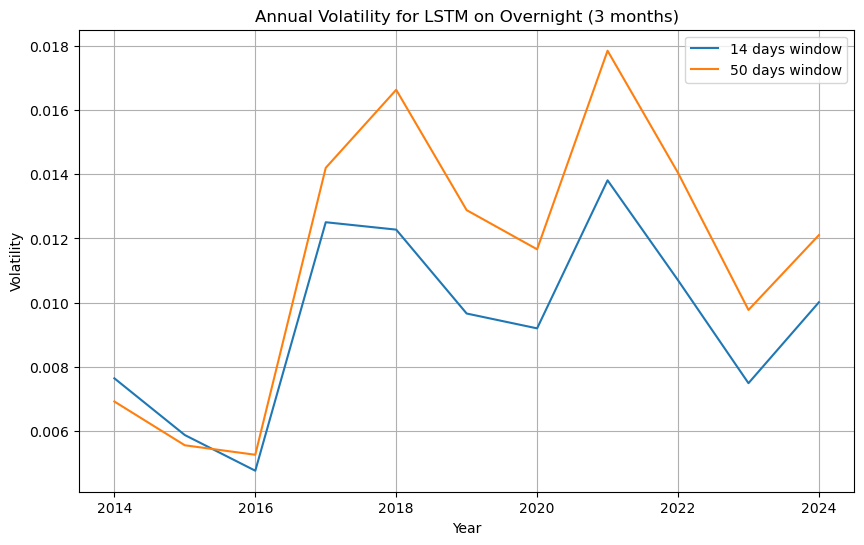

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Annual Statistics for CNN model on Overnight dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    534.771057    589.745178    569.718933    0.005971
1   2015    460.019653    634.302246    482.087585    0.005368
2   2016    576.423462   1063.602783    744.087585    0.005569
3   2017    976.771301  19394.195312   2742.786133    0.019895
4   2018   3505.961670  17496.986328   7357.812500    0.019395
5   2019   3640.711182  12623.728516   8205.603516    0.015793
6   2020   5456.043945  27159.759766   9959.704590    0.015675
7   2021  27792.828125  66991.000000  48730.292969    0.020188
8   2022  16586.212891  49212.046875  23893.748047    0.016956
9   2023  16976.970703  44880.476562  28381.634766    0.011503
10  2024  40513.890625  72641.671875  64084.744141    0.013107


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Overnight dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    646.460815    677.627747    668.794495    0.002567
1   2015    591.951721    716.977417    600.628113    0.001967
2   2016    687.485291   1083.537720    861.396545    0.002881
3   2017   1091.914185  18782.474609   2904.958252    0.012890
4   2018   3347.744385  17204.259766   6945.750488    0.018976
5   2019   3608.849121  12052.214844   7775.252441    0.014060
6   2020   5386.539062  26630.664062   9720.796875    0.013649
7   2021  27226.736328  66595.835938  48613.617188    0.018345
8   2022  16163.099609  48716.476562  23684.515625    0.015672
9   2023  16648.791016  44348.789062  28170.720703    0.010931
10  2024  40192.343750  72377.851562  63117.882812    0.011431


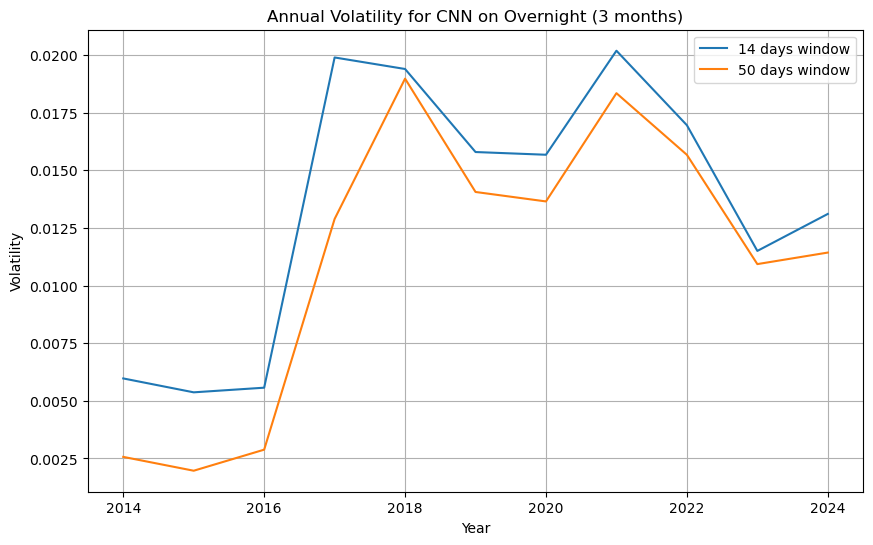

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Annual Statistics for RNN model on Overnight dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    252.466202    380.663086    315.651672    0.046867
1   2015    131.953659    428.022369    208.784683    0.046663
2   2016    300.628204    904.001038    532.518494    0.029753
3   2017    709.208008  20417.783203   2491.107910    0.053268
4   2018   2954.408936  18221.101562   6978.806152    0.049560
5   2019   3238.698730  12984.561523   7797.244629    0.041362
6   2020   3904.458740  28078.587891   9739.693359    0.038248
7   2021  28113.677734  66523.164062  48481.914062    0.026009
8   2022  15240.024414  48125.738281  23401.255859    0.026929
9   2023  16495.914062  44938.144531  27820.572266    0.017609
10  2024  39838.933594  72068.976562  63963.353516    0.016017


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Annual Statistics for RNN model on Overnight dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    473.486267    624.805115    541.044495    0.036705
1   2015    353.130798    671.715698    419.405701    0.034620
2   2016    521.741333   1232.143677    787.861450    0.032699
3   2017    958.766724  20404.529297   2940.550049    0.057156
4   2018   3382.076172  17991.078125   7437.041992    0.054638
5   2019   3660.299072  13937.772461   8316.854492    0.050412
6   2020   4555.850098  27652.025391  10207.811523    0.046268
7   2021  29691.720703  65973.156250  47854.679688    0.036585
8   2022  15680.049805  47633.089844  23493.806641    0.033576
9   2023  16718.259766  44460.925781  27937.783203    0.022917
10  2024  39368.328125  71398.234375  62518.410156    0.024242


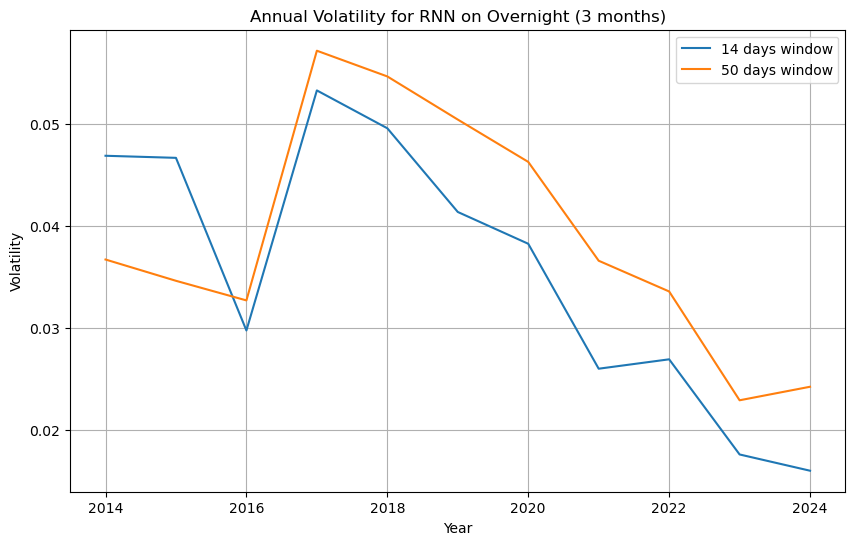

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Annual Statistics for LSTM model on Overnight dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    325.309174    399.593292    370.071625    0.009322
1   2015    213.786850    460.303162    251.819580    0.007842
2   2016    380.396179    932.637329    586.538300    0.005382
3   2017    835.117676  18683.335938   2583.071777    0.012657
4   2018   3363.866943  16457.638672   7071.573242    0.011956
5   2019   3478.807617  12017.785156   7938.209473    0.009438
6   2020   5426.079102  26551.658203   9723.880371    0.008961
7   2021  27329.923828  66005.515625  48224.417969    0.014745
8   2022  16537.611328  48746.128906  23541.107422    0.010953
9   2023  16831.957031  44683.566406  28116.781250    0.007561
10  2024  40473.292969  72352.085938  63059.833984    0.010871


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

Annual Statistics for LSTM model on Overnight dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    718.369263    792.300659    761.967590    0.005876
1   2015    605.250671    855.795044    644.460632    0.004648
2   2016    773.436218   1339.418213    982.960571    0.004665
3   2017   1227.944946  19404.371094   3005.065918    0.013853
4   2018   3776.176758  17377.029297   7572.711914    0.016708
5   2019   3903.801270  12635.407227   8406.088867    0.012950
6   2020   5773.840332  27646.982422  10259.423828    0.011868
7   2021  28481.472656  68109.750000  49983.152344    0.019588
8   2022  17252.033203  49489.429688  24287.208984    0.015138
9   2023  17488.130859  45968.410156  28943.214844    0.010307
10  2024  41748.847656  73775.867188  65435.007812    0.013574


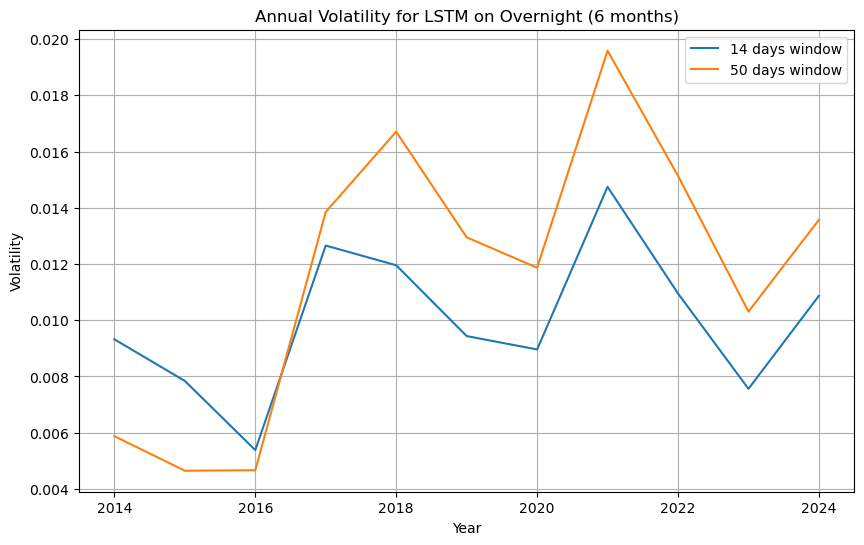

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Overnight dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    567.717224    618.141357    595.878296    0.003155
1   2015    526.039612    648.775208    535.095520    0.001931
2   2016    600.349182   1002.436646    744.317139    0.002749
3   2017    969.041077  19267.822266   2909.391113    0.014870
4   2018   3700.195312  17336.501953   7205.404297    0.017879
5   2019   3766.878174  12808.864258   8051.676270    0.014806
6   2020   5576.695801  26864.169922   9803.511719    0.016327
7   2021  27567.562500  66435.250000  48480.230469    0.021203
8   2022  16311.177734  48559.445312  23760.207031    0.017062
9   2023  16749.644531  44547.238281  28155.386719    0.012491
10  2024  40049.007812  71981.531250  63233.417969    0.014258


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Overnight dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    385.401764    404.170319    400.286530    0.002999
1   2015    356.798065    433.649323    372.074860    0.001898
2   2016    404.093872    823.195862    532.286987    0.003893
3   2017    837.229248  17974.267578   2799.637939    0.011382
4   2018   4262.262695  16938.833984   7483.127930    0.015201
5   2019   3937.697021  12217.663086   8089.564453    0.011729
6   2020   6366.401855  26246.898438   9870.110352    0.011445
7   2021  26607.058594  65090.296875  48243.417969    0.017233
8   2022  17072.115234  48970.421875  23660.886719    0.013639
9   2023  17124.324219  43800.644531  28079.865234    0.010409
10  2024  39989.968750  70317.031250  62912.587891    0.011289


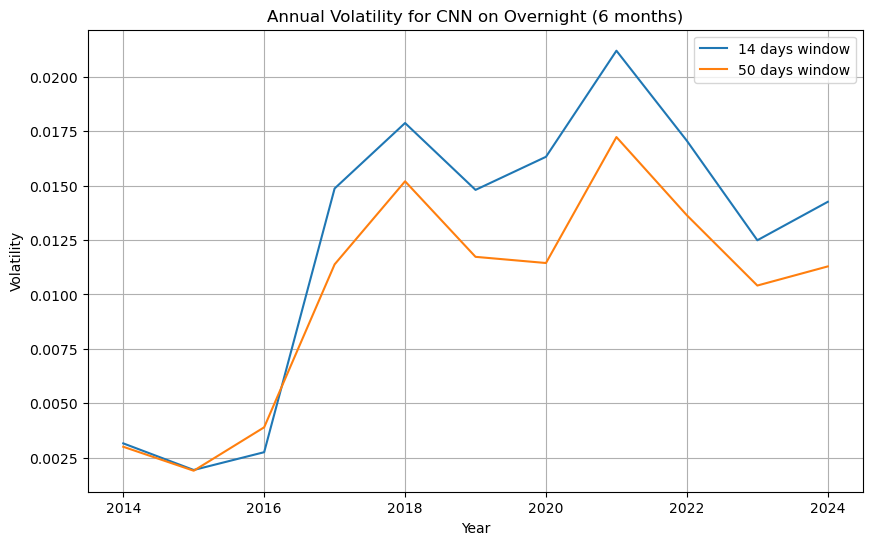

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Annual Statistics for RNN model on Overnight dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    355.444061    468.791412    409.030060    0.021994
1   2015    228.225723    520.411499    288.799713    0.021055
2   2016    417.171478   1040.027100    643.634277    0.016272
3   2017    869.971252  19894.884766   2725.799316    0.033401
4   2018   3407.270020  17942.890625   7326.070312    0.030998
5   2019   3648.381104  13067.054688   8150.226562    0.026473
6   2020   5026.528809  28237.449219  10115.367188    0.025317
7   2021  29184.330078  66949.382812  48912.199219    0.025560
8   2022  16371.628906  48401.343750  24060.931641    0.022380
9   2023  17134.949219  45212.753906  28506.396484    0.014509
10  2024  40705.730469  71929.421875  64175.679688    0.016505


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Annual Statistics for RNN model on Overnight dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    856.163574   1054.751953    973.727234    0.032771
1   2015    760.280090   1170.679321    865.241638    0.023431
2   2016    934.716797   1647.550537   1171.596924    0.030884
3   2017   1417.650513  22384.166016   3353.051270    0.059708
4   2018   3541.384033  19274.476562   8372.583984    0.053737
5   2019   3800.343994  15308.912109   9357.809570    0.050071
6   2020   5231.190918  30840.792969  11588.089844    0.043837
7   2021  31504.072266  68530.453125  50635.289062    0.032896
8   2022  17579.275391  50222.386719  25609.052734    0.030465
9   2023  18536.525391  47208.359375  30265.292969    0.020927
10  2024  42050.929688  74182.828125  65725.781250    0.019381


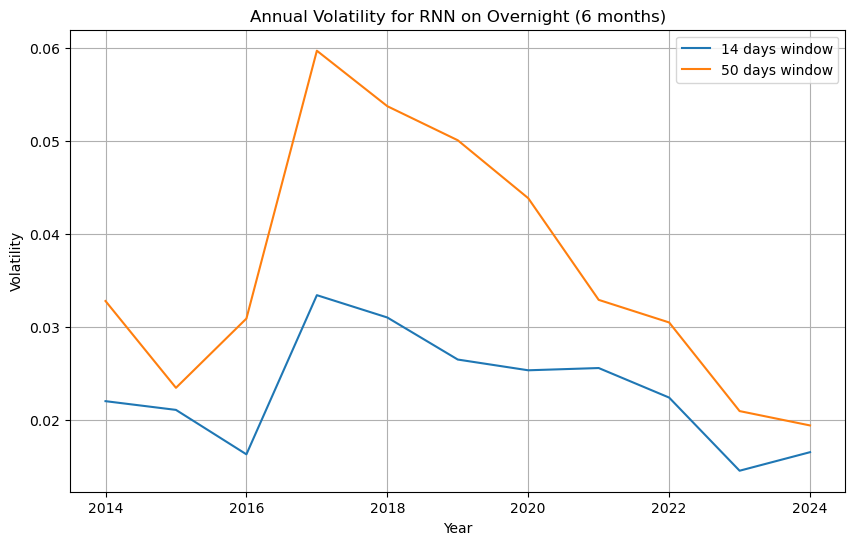

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Annual Statistics for LSTM model on Overnight dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    -16.830851     55.203968     24.633574    1.072599
1   2015   -127.532951    115.794189    -87.188507    0.262319
2   2016     34.862881    575.784546    233.885880    0.020581
3   2017    461.705627  17659.769531   2151.104736    0.017035
4   2018   2868.805908  15511.374023   6442.722168    0.013902
5   2019   2999.257812  11290.961914   7283.393555    0.011037
6   2020   4661.140625  25158.949219   8991.476562    0.010385
7   2021  25913.136719  62693.992188  45785.730469    0.015090
8   2022  15436.817383  46241.589844  22115.755859    0.011710
9   2023  15738.046875  42417.746094  26481.865234    0.008080
10  2024  38205.425781  68845.632812  59845.437500    0.011013


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Annual Statistics for LSTM model on Overnight dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    170.852966    244.668152    213.890976    0.020680
1   2015     56.249737    306.585663     97.678238    0.026374
2   2016    225.172607    779.377197    430.598633    0.011158
3   2017    666.466980  18373.716797   2413.607666    0.017038
4   2018   3177.652588  16248.275391   6868.561523    0.017239
5   2019   3302.293457  11830.090820   7735.528320    0.013464
6   2020   5087.061035  26060.537109   9492.423828    0.011983
7   2021  26800.388672  65228.722656  47527.894531    0.017660
8   2022  16253.155273  48524.328125  23092.089844    0.013964
9   2023  16512.687500  44162.964844  27602.208984    0.009816
10  2024  39885.562500  71177.875000  62561.527344    0.011917


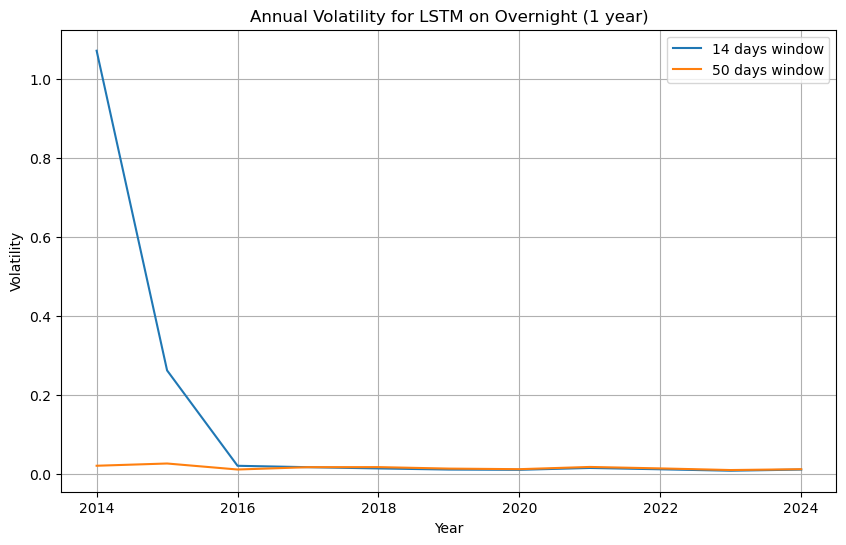

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Overnight dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    634.874146    702.107910    672.001221    0.004374
1   2015    583.971741    747.868530    594.261719    0.002332
2   2016    677.130798   1192.220093    866.541016    0.003915
3   2017   1132.240112  19858.218750   2920.230225    0.014486
4   2018   3728.859131  17836.914062   7468.118652    0.016572
5   2019   3836.505371  12880.523438   8292.823242    0.013420
6   2020   5688.500488  27300.283203  10118.615234    0.013433
7   2021  27919.220703  67527.070312  49195.226562    0.018842
8   2022  16818.574219  50021.851562  24133.466797    0.015396
9   2023  17158.861328  45361.484375  28583.416016    0.010588
10  2024  40771.105469  73313.523438  64384.386719    0.012745


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Overnight dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    378.125885    387.477905    384.758911    0.001658
1   2015    350.836578    398.510651    356.020294    0.001283
2   2016    390.084106    621.654785    441.851242    0.002018
3   2017    634.784180  17803.906250   3040.769775    0.011208
4   2018   4312.379395  16376.478516   7355.916992    0.015399
5   2019   4026.860596  12195.461914   7945.939453    0.011469
6   2020   6169.542480  25955.294922   9660.446289    0.011543
7   2021  26500.095703  66502.093750  48599.472656    0.017478
8   2022  16729.875000  48704.121094  23613.992188    0.014588
9   2023  16779.503906  44265.906250  28004.107422    0.010870
10  2024  40178.187500  71568.679688  63653.427734    0.011306


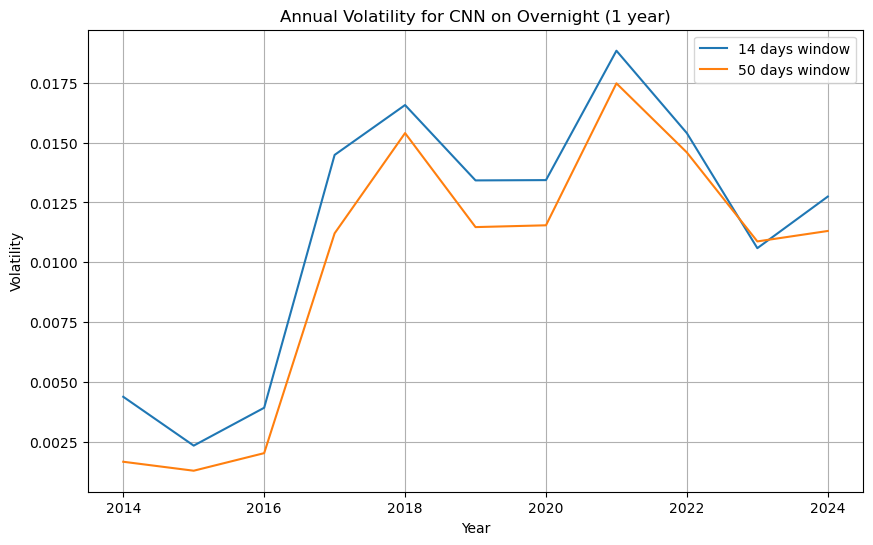

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Annual Statistics for RNN model on Overnight dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    411.498474    538.210571    460.685730    0.022585
1   2015    289.487152    569.777283    356.372803    0.019418
2   2016    465.363129   1061.534790    679.333618    0.016686
3   2017    863.702087  19111.392578   2585.412354    0.039601
4   2018   3082.597168  17077.292969   6704.300781    0.036478
5   2019   3368.504150  12718.333008   7548.437012    0.031321
6   2020   4178.065918  27156.984375   9420.865234    0.029734
7   2021  28165.181641  66488.843750  47791.570312    0.029594
8   2022  14883.692383  47239.136719  22745.417969    0.027254
9   2023  15917.983398  44055.015625  27215.220703    0.017572
10  2024  39451.195312  71871.367188  63656.652344    0.018358


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Annual Statistics for RNN model on Overnight dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014   -139.517776    125.987984     20.733215    5.251503
1   2015   -245.465073    241.164185   -107.816666    1.285512
2   2016    -85.835594    771.738098    252.138443    0.639874
3   2017    262.512238  20754.148438   2407.578857    0.142398
4   2018   2890.632812  17160.867188   7012.351562    0.067405
5   2019   2889.850098  13347.853516   7898.437500    0.066680
6   2020   4922.738770  27369.837891   9809.035156    0.054999
7   2021  28352.449219  66122.093750  48219.484375    0.032040
8   2022  15888.289062  47595.371094  23275.087891    0.031028
9   2023  16549.298828  44359.722656  27727.093750    0.020292
10  2024  39438.929688  72045.140625  62930.486328    0.019820


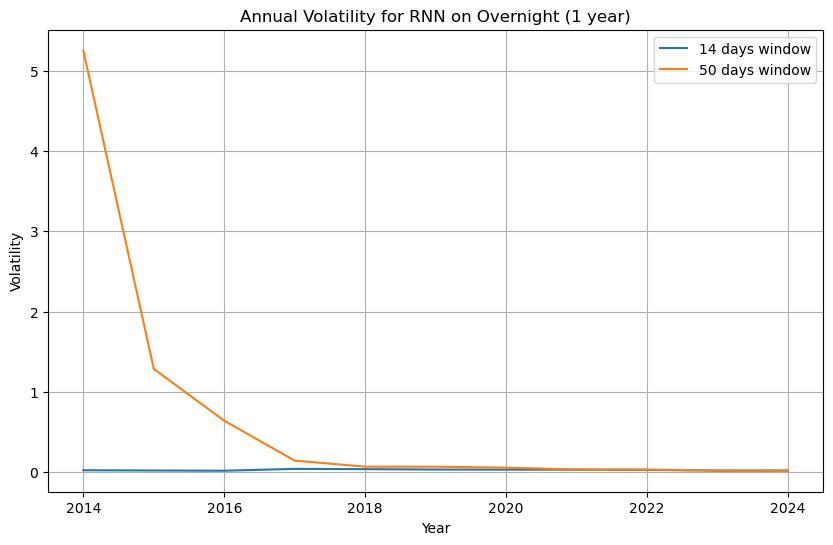

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Annual Statistics for LSTM model on Day dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    -22.528082     51.963711     19.009232    0.903896
1   2015   -135.276123    109.627106    -95.951332    0.138163
2   2016     29.289392    563.426025    233.455917    0.021335
3   2017    473.989990  18163.324219   2202.674316    0.016575
4   2018   2952.239990  15961.497070   6654.031738    0.013467
5   2019   3077.797119  11528.947266   7481.592773    0.010739
6   2020   4919.664551  25388.900391   9237.992188    0.010050
7   2021  26016.376953  64914.179688  47424.664062    0.015649
8   2022  15940.990234  48498.257812  22889.501953    0.011787
9   2023  16245.976562  43745.574219  27356.416016    0.008050
10  2024  39596.828125  71192.625000  62156.562500    0.011470


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step

Annual Statistics for LSTM model on Day dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    458.885406    531.795044    499.834412    0.009128
1   2015    342.639679    593.805176    384.475250    0.007516
2   2016    510.810516   1053.680420    715.973145    0.006496
3   2017    952.218628  18954.187500   2704.805908    0.015616
4   2018   3439.871094  16878.015625   7191.188965    0.017901
5   2019   3584.131348  12270.408203   8023.812012    0.013983
6   2020   5289.103516  26324.937500   9822.296875    0.012728
7   2021  27009.273438  66509.804688  48776.234375    0.020282
8   2022  16640.736328  49225.843750  23633.107422    0.016089
9   2023  16893.578125  44931.664062  28097.892578    0.010942
10  2024  40529.742188  72361.257812  63679.722656    0.013673


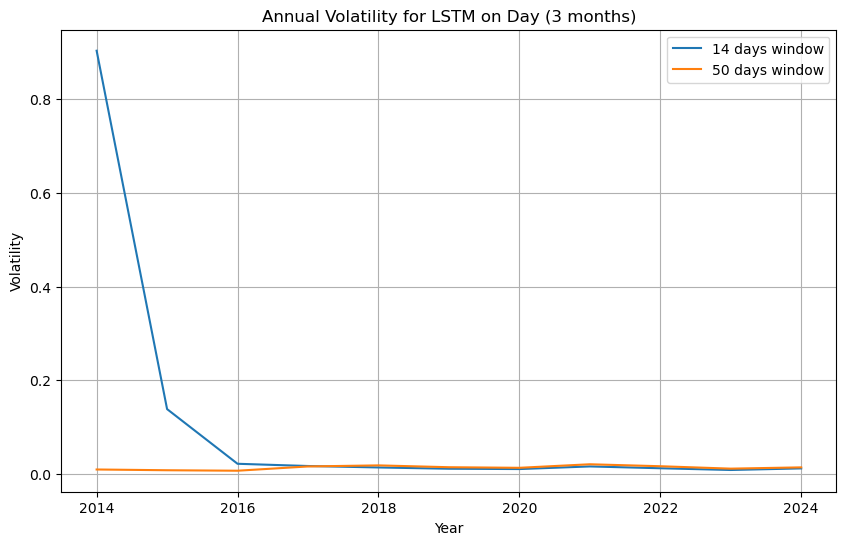

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Day dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    196.104156    239.469696    219.103149    0.007377
1   2015    143.633316    260.068115    158.314743    0.006236
2   2016    222.777054    538.797241    330.755676    0.005860
3   2017    511.274750  18540.453125   2473.439697    0.017147
4   2018   3331.328857  16543.443359   6821.227051    0.017263
5   2019   3436.647217  12005.689453   7653.340820    0.013521
6   2020   5000.591309  24967.927734   9352.570312    0.013487
7   2021  25694.078125  63406.113281  46315.164062    0.017164
8   2022  15758.310547  48501.164062  22763.564453    0.014528
9   2023  16092.671875  42661.734375  26948.669922    0.009972
10  2024  38435.671875  68971.906250  60555.042969    0.011346


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Day dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    417.089600    430.182068    425.700562    0.002098
1   2015    378.154114    451.856079    379.975037    0.001370
2   2016    442.801453    839.892639    600.571045    0.003195
3   2017    852.402466  18371.710938   2896.843018    0.010067
4   2018   4139.511719  17206.064453   7473.136719    0.015020
5   2019   4010.672852  12431.099609   8155.421387    0.011342
6   2020   6359.310059  26075.062500  10047.409180    0.010720
7   2021  26573.181641  66855.132812  49121.085938    0.016121
8   2022  16910.041016  50876.214844  24189.255859    0.013252
9   2023  17156.119141  44847.035156  28639.287109    0.009935
10  2024  40766.414062  71852.773438  64419.378906    0.010208


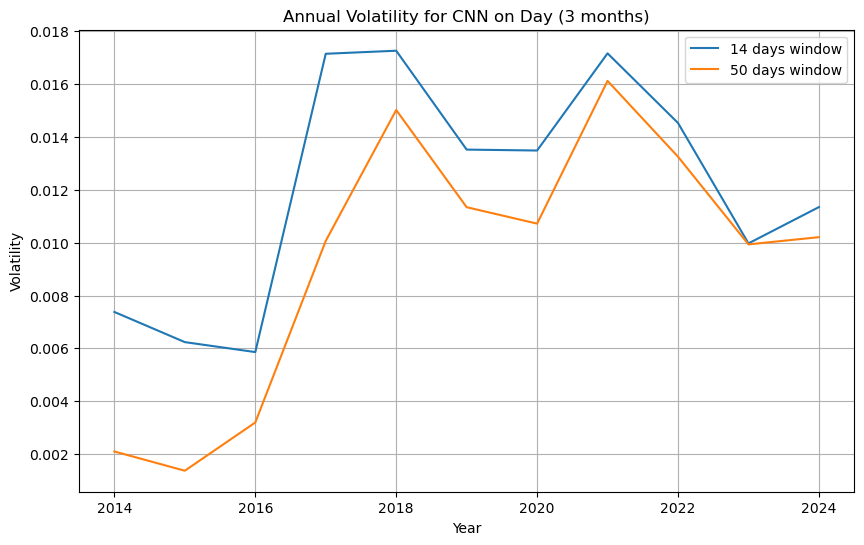

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Annual Statistics for RNN model on Day dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    -28.995590     86.243752     21.963171    1.266036
1   2015   -161.099258    127.458328    -93.257027    0.248484
2   2016     24.450329    646.995911    249.413681    0.071124
3   2017    463.362915  19676.037109   2307.143066    0.048943
4   2018   2976.177979  17734.871094   6845.203613    0.037227
5   2019   3162.657227  12993.159180   7744.723633    0.031536
6   2020   4700.296387  27348.722656   9658.778320    0.030402
7   2021  27966.007812  67330.578125  48700.980469    0.034845
8   2022  15763.907227  48217.765625  23727.423828    0.028667
9   2023  16656.703125  45106.203125  28181.332031    0.019561
10  2024  40450.750000  72504.640625  63820.382812    0.022446


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Annual Statistics for RNN model on Day dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    164.567230    492.495392    350.174286    0.164643
1   2015     -3.120157    510.470154    179.503693    0.607836
2   2016    297.799194   1186.839111    674.454102    0.101039
3   2017    691.386536  20849.550781   3319.659180    0.100987
4   2018   4181.868652  18455.269531   8133.459961    0.071031
5   2019   3860.523193  14223.080078   8936.002930    0.065239
6   2020   5763.168945  28283.257812  10820.662109    0.061016
7   2021  28198.000000  66310.148438  48610.171875    0.029851
8   2022  16563.052734  48230.964844  24096.335938    0.031130
9   2023  17152.371094  45067.250000  28307.593750    0.021220
10  2024  40084.003906  72262.132812  63738.988281    0.018135


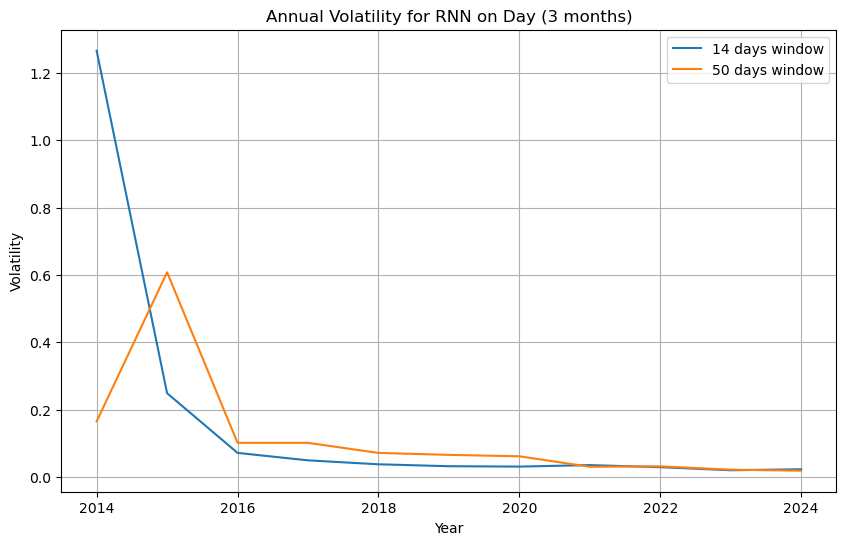

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Annual Statistics for LSTM model on Day dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    231.367188    306.146881    272.684937    0.013705
1   2015    115.649117    364.163239    157.326935    0.012750
2   2016    282.773071    817.531189    486.423157    0.007054
3   2017    721.835754  18315.580078   2454.776611    0.013971
4   2018   3201.610352  16090.351562   6884.930176    0.012811
5   2019   3329.014893  11781.612305   7725.127441    0.010139
6   2020   5090.515625  25344.687500   9452.937500    0.009543
7   2021  25943.449219  64147.824219  47227.683594    0.014073
8   2022  16130.145508  48809.855469  23018.310547    0.010910
9   2023  16427.316406  43728.878906  27437.070312    0.007581
10  2024  39582.582031  70376.929688  61547.335938    0.010231


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Annual Statistics for LSTM model on Day dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    312.113586    386.714355    352.703674    0.013576
1   2015    194.752884    448.909576    235.704330    0.012467
2   2016    365.034851    921.594727    575.949341    0.008736
3   2017    816.825684  18916.224609   2600.973877    0.017140
4   2018   3366.401123  16922.591797   7166.954102    0.018047
5   2019   3500.651855  12236.969727   7997.793457    0.014248
6   2020   5289.259277  26418.718750   9816.371094    0.012817
7   2021  27055.107422  67069.585938  48839.855469    0.019749
8   2022  16710.931641  49835.703125  23729.453125    0.015468
9   2023  16966.599609  45137.363281  28218.017578    0.010561
10  2024  40746.816406  73062.562500  64278.062500    0.013598


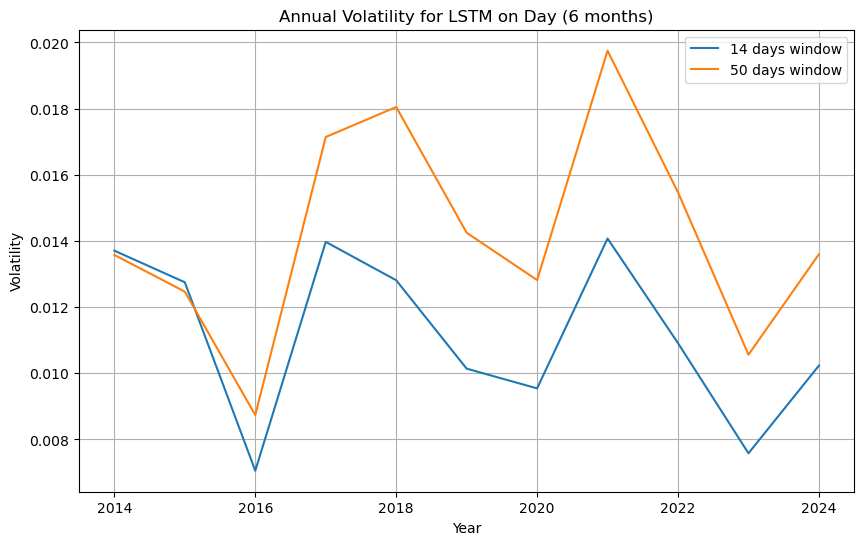

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Day dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    653.475525    732.705994    696.971375    0.005795
1   2015    551.616699    782.583313    580.564026    0.004234
2   2016    703.835266   1219.525879    905.331665    0.004160
3   2017   1164.274048  19998.335938   2884.843750    0.014871
4   2018   3627.470459  18047.605469   7483.312988    0.016640
5   2019   3749.302490  13356.894531   8400.838867    0.013740
6   2020   5813.856445  26917.074219  10332.653320    0.013832
7   2021  27439.636719  67686.296875  49403.835938    0.018520
8   2022  17093.781250  51599.910156  24339.193359    0.015017
9   2023  17397.408203  45156.960938  28682.324219    0.010800
10  2024  40874.332031  73526.882812  64693.492188    0.012645


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Day dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    449.830231    466.007721    460.801361    0.002242
1   2015    414.462646    500.860657    421.048462    0.001296
2   2016    477.355133    874.178894    660.354004    0.002878
3   2017    885.180298  18404.988281   2650.408691    0.012537
4   2018   3646.209717  17151.728516   6913.609375    0.022069
5   2019   3608.570312  12740.323242   7792.921875    0.017965
6   2020   5372.792969  26397.566406   9540.384766    0.017513
7   2021  26658.736328  66405.679688  48157.832031    0.021985
8   2022  16271.750977  49626.050781  23615.732422    0.017642
9   2023  16529.496094  44340.542969  28019.708984    0.013367
10  2024  39672.167969  72183.453125  62808.441406    0.014507


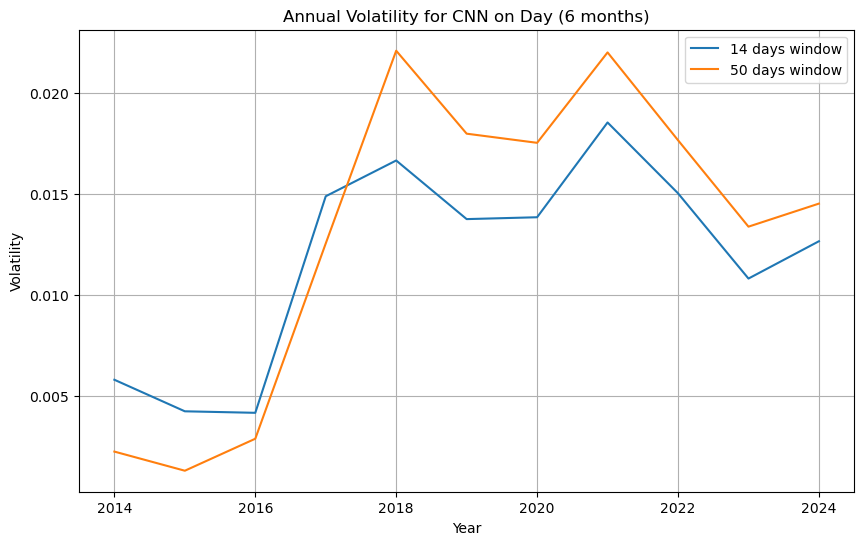

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Annual Statistics for RNN model on Day dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    568.955933    718.414307    626.363037    0.024726
1   2015    427.101379    746.764832    509.990173    0.018585
2   2016    626.551758   1276.202393    857.529846    0.018508
3   2017   1038.140503  19717.857422   2880.157471    0.046140
4   2018   3447.948242  18074.437500   7317.158203    0.044215
5   2019   3754.916504  13273.900391   8085.376465    0.038037
6   2020   4249.815430  27161.636719  10018.384766    0.038188
7   2021  27384.072266  65758.593750  47463.015625    0.031507
8   2022  15696.818359  47058.796875  23350.476562    0.028800
9   2023  16605.728516  43761.210938  27522.759766    0.019010
10  2024  38660.574219  70596.695312  62456.757812    0.017173


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Annual Statistics for RNN model on Day dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    -44.678585    169.543411     62.433777    4.284508
1   2015   -118.127838    198.968872    -24.129333    6.808207
2   2016     15.724777    631.389465    240.224548    0.373135
3   2017    333.856659  19863.798828   2045.015503    0.118670
4   2018   2545.456787  17669.818359   6574.849121    0.074338
5   2019   2680.886719  13015.885742   7396.090820    0.067794
6   2020   3987.530762  27182.189453   9480.991211    0.056749
7   2021  27540.500000  67305.117188  48097.019531    0.036675
8   2022  14956.781250  48155.167969  23255.806641    0.035688
9   2023  16240.791992  44540.203125  27661.218750    0.024062
10  2024  39379.136719  71463.359375  63477.207031    0.021436


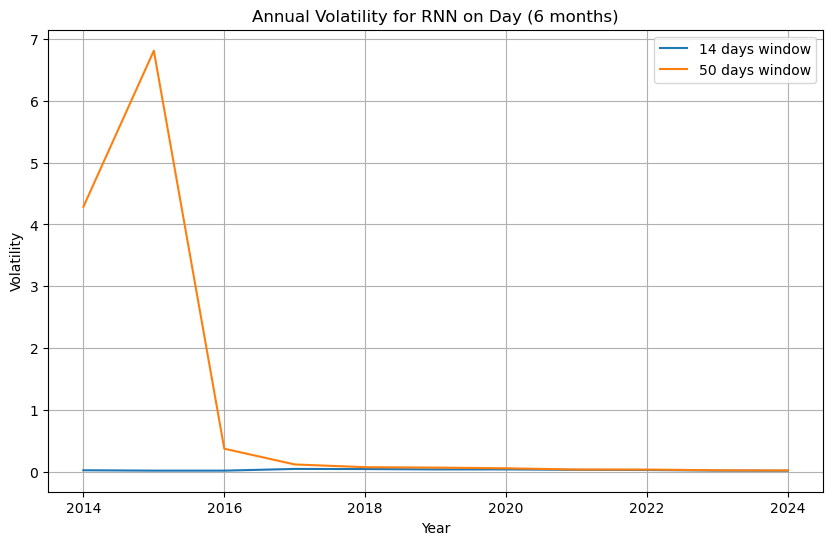

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Annual Statistics for LSTM model on Day dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    323.880615    399.006866    364.798004    0.009836
1   2015    209.527206    454.973236    250.099350    0.007922
2   2016    375.198059    902.205017    576.978516    0.005577
3   2017    812.958008  18300.189453   2529.891113    0.012833
4   2018   3284.834717  16085.639648   6929.958008    0.012182
5   2019   3404.122803  11783.594727   7777.211426    0.009620
6   2020   5216.557129  25299.550781   9500.003906    0.009048
7   2021  25895.994141  64204.742188  47482.980469    0.013373
8   2022  16204.182617  49055.597656  23169.611328    0.010382
9   2023  16489.767578  43777.707031  27549.580078    0.007255
10  2024  39838.105469  70316.882812  61697.914062    0.009699


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Annual Statistics for LSTM model on Day dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    693.718811    768.313965    732.696289    0.006396
1   2015    578.142944    827.724121    621.119507    0.004916
2   2016    745.503357   1286.334961    949.941284    0.004966
3   2017   1178.501343  18814.892578   2917.459473    0.014425
4   2018   3656.359131  16893.519531   7349.573730    0.017346
5   2019   3793.016357  12341.797852   8157.015137    0.013530
6   2020   5449.569336  26012.490234   9946.363281    0.012374
7   2021  26660.929688  65863.226562  48195.019531    0.019213
8   2022  16737.990234  49369.273438  23517.345703    0.015174
9   2023  16936.255859  44579.222656  27944.359375    0.010427
10  2024  40316.046875  71600.289062  63178.980469    0.013241


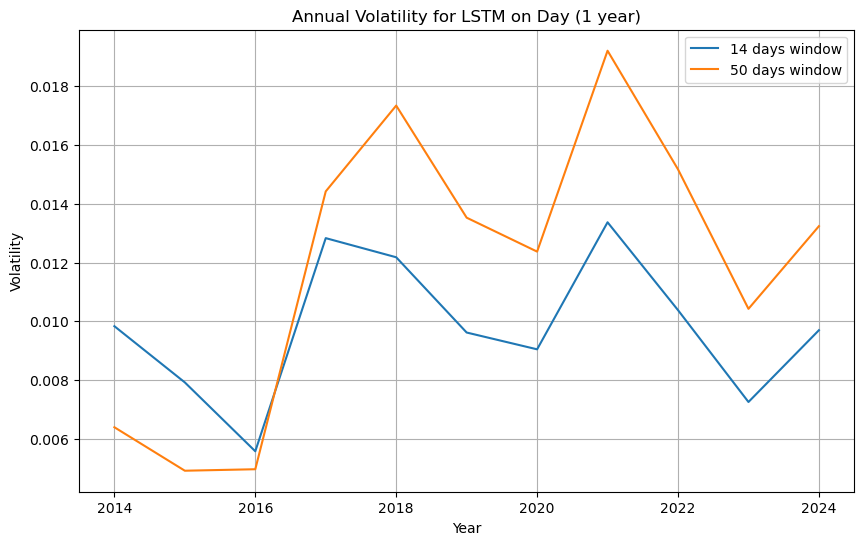

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Day dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    401.698792    446.482208    425.843475    0.004810
1   2015    344.885345    474.619141    362.172028    0.003766
2   2016    429.138031    797.273193    555.739502    0.004780
3   2017    734.614929  18830.212891   2489.015137    0.017396
4   2018   3244.650146  16912.175781   6906.929199    0.016636
5   2019   3380.128418  12121.855469   7676.105469    0.013459
6   2020   5218.749023  25480.417969   9484.084961    0.013071
7   2021  26119.150391  65164.320312  47584.339844    0.017647
8   2022  16081.180664  49944.046875  23235.666016    0.014161
9   2023  16392.021484  43823.039062  27508.486328    0.009974
10  2024  39407.031250  71053.726562  62391.296875    0.011900


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Day dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    406.796143    433.100372    426.247192    0.003821
1   2015    359.558777    469.625488    369.684937    0.002919
2   2016    433.585907    702.572510    536.530701    0.003465
3   2017    715.425842  18041.789062   2823.551514    0.012582
4   2018   4100.965332  17735.728516   7700.198242    0.016128
5   2019   4131.119141  12569.105469   8566.963867    0.012261
6   2020   6394.864746  26958.544922  10240.337891    0.011967
7   2021  27361.472656  68641.343750  50414.175781    0.017980
8   2022  17009.695312  52172.234375  24641.423828    0.014876
9   2023  17292.320312  45900.472656  29162.677734    0.011159
10  2024  41981.375000  73961.804688  66408.156250    0.011958


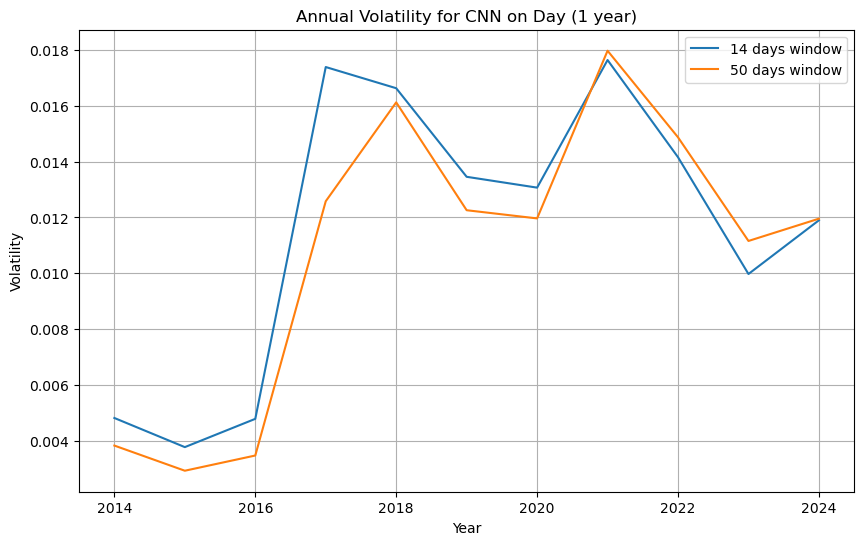

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Annual Statistics for RNN model on Day dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    564.972778    714.314026    629.463379    0.022447
1   2015    433.479919    748.763489    521.269104    0.017685
2   2016    617.691345   1228.055664    848.922119    0.017257
3   2017   1019.653809  19595.875000   2797.715576    0.045837
4   2018   3221.719482  17626.308594   6952.510742    0.044488
5   2019   3503.378662  12586.698242   7690.695312    0.036653
6   2020   4047.856201  27014.419922   9514.354492    0.034827
7   2021  27148.945312  65928.882812  47575.531250    0.024770
8   2022  15032.209961  47282.078125  22861.921875    0.025996
9   2023  16017.008789  43605.925781  27071.205078    0.016588
10  2024  39023.781250  71316.265625  63317.167969    0.014303


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Annual Statistics for RNN model on Day dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    737.397949    882.171936    806.890747    0.029104
1   2015    619.316528    944.510254    699.495850    0.020332
2   2016    788.681641   1429.660278   1030.154907    0.021281
3   2017   1232.144043  20846.529297   3087.772217    0.043608
4   2018   3192.440918  18448.177734   7266.385742    0.054646
5   2019   3757.933594  13722.731445   8227.859375    0.046344
6   2020   4960.332520  27724.492188  10276.378906    0.043042
7   2021  28537.341797  67433.742188  48724.722656    0.030033
8   2022  16138.675781  48388.335938  23692.031250    0.029974
9   2023  16755.960938  45279.656250  28239.248047    0.020421
10  2024  39945.515625  72337.468750  63848.257812    0.019632


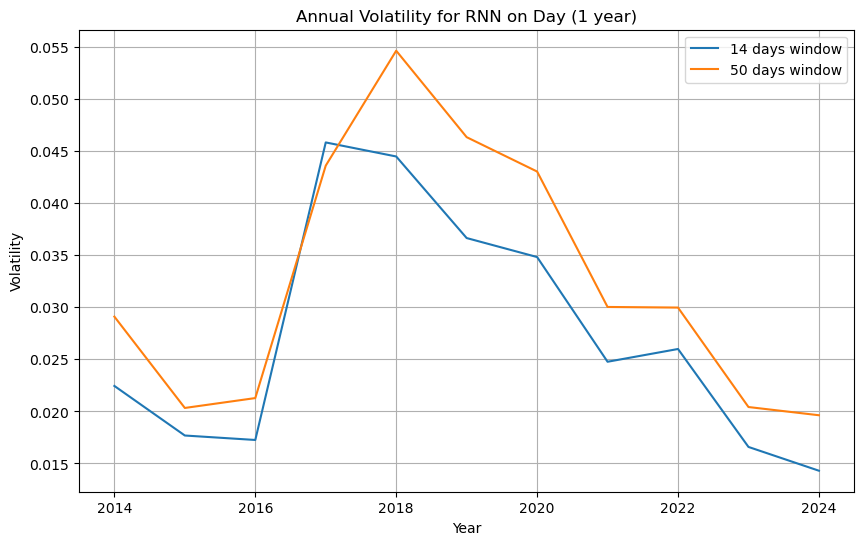

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    112.757469    185.225204    156.392776    0.023385
1   2015     -0.168505    247.474152     40.446918    0.171256
2   2016    166.337891    717.150330    370.703949    0.009595
3   2017    608.936340  18268.804688   2346.322021    0.014695
4   2018   3099.608398  16059.698242   6767.715332    0.012774
5   2019   3222.931885  11692.838867   7637.850586    0.010113
6   2020   5037.047852  25957.115234   9402.656250    0.009488
7   2021  26709.666016  64800.464844  47616.335938    0.013672
8   2022  16121.487305  48330.339844  23042.107422    0.010659
9   2023  16414.968750  43917.386719  27573.214844    0.007431
10  2024  39922.039062  71013.656250  62152.324219    0.009968


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    889.964966    966.981445    932.180359    0.005068
1   2015    773.957031   1029.567383    816.430481    0.003910
2   2016    944.020081   1515.895996   1153.868408    0.004184
3   2017   1392.897583  19685.919922   3172.736084    0.013912
4   2018   3920.891113  17701.087891   7705.450684    0.017573
5   2019   4065.815186  12894.494141   8565.940430    0.013634
6   2020   5792.656738  27951.841797  10414.036133    0.012681
7   2021  28826.382812  68135.578125  49676.667969    0.021064
8   2022  17317.361328  49135.492188  24452.304688    0.016585
9   2023  17580.820312  45867.929688  29007.048828    0.011031
10  2024  41568.496094  73810.664062  65061.246094    0.014313


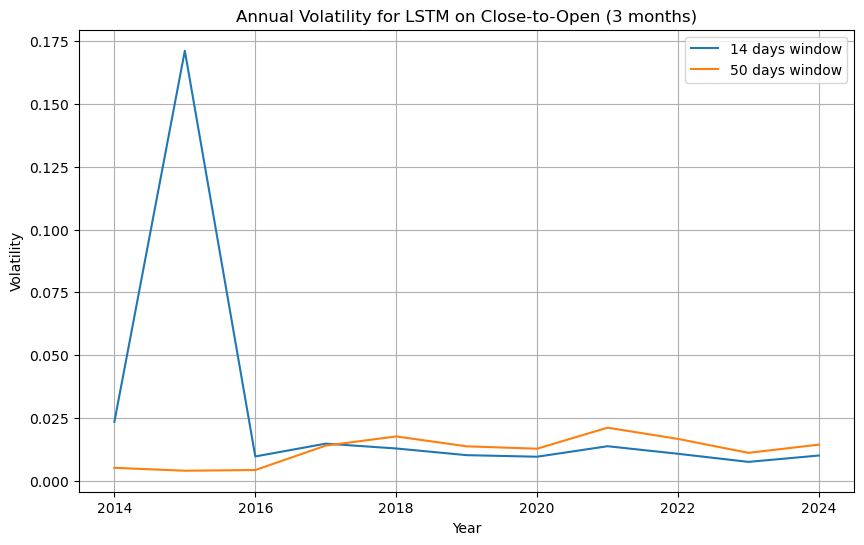

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    208.841034    253.782059    237.536743    0.011644
1   2015    144.731659    291.095398    165.565140    0.010989
2   2016    241.798187    673.996338    381.520081    0.008593
3   2017    608.960693  17882.968750   2283.194824    0.020816
4   2018   2999.074707  16066.944336   6440.442383    0.019551
5   2019   3131.373047  11480.284180   7233.839844    0.015778
6   2020   4743.173828  25016.150391   8940.888672    0.015827
7   2021  25524.974609  62181.414062  44962.148438    0.021245
8   2022  15090.818359  45323.621094  21940.859375    0.017890
9   2023  15494.623047  41653.914062  26103.460938    0.012085
10  2024  37196.281250  67463.367188  59323.195312    0.014276


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    283.012207    307.195801    298.489197    0.004812
1   2015    225.609299    336.233124    241.002411    0.004481
2   2016    306.082825    645.247742    435.640656    0.004779
3   2017    653.446045  17881.677734   2686.179443    0.013379
4   2018   3189.440674  16145.797852   6503.733398    0.019256
5   2019   3201.731689  11495.920898   7312.127930    0.014730
6   2020   5042.124023  24994.011719   9147.953125    0.013574
7   2021  25622.455078  63658.144531  46090.699219    0.019421
8   2022  15876.978516  45715.867188  22479.017578    0.015836
9   2023  16045.305664  42638.246094  26801.126953    0.011377
10  2024  38109.003906  68273.382812  60062.578125    0.012776


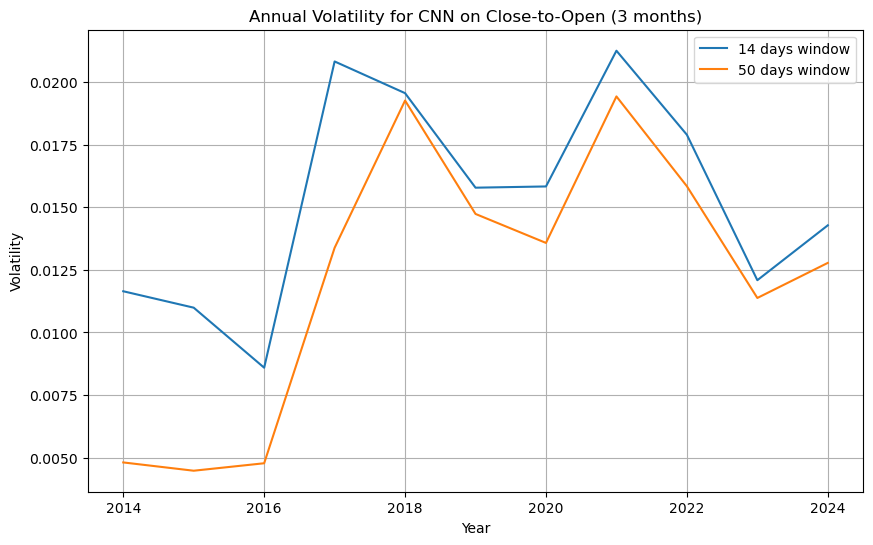

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 3 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    -99.272766     37.015484    -46.058395    0.739224
1   2015   -241.439819     72.990807   -173.490036    0.481609
2   2016    -40.829670    670.224792    213.685272    0.425310
3   2017    449.923798  20554.683594   2498.915283    0.056351
4   2018   3173.504639  18981.199219   7409.593262    0.041972
5   2019   3447.577148  14091.550781   8320.400391    0.036271
6   2020   4940.186035  29178.281250  10433.021484    0.033161
7   2021  30392.642578  67153.921875  49432.898438    0.031977
8   2022  16447.199219  48859.917969  24884.646484    0.028022
9   2023  17724.482422  45567.664062  29244.107422    0.018590
10  2024  41130.742188  71785.570312  63929.460938    0.020364


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 3 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    497.277618    664.091980    584.906372    0.064893
1   2015    384.866577    742.021606    463.919403    0.045674
2   2016    576.701111   1253.965698    833.028748    0.043866
3   2017   1062.234375  19766.730469   2932.847656    0.067099
4   2018   3318.574951  17081.826172   7124.559570    0.059682
5   2019   3206.189209  12773.803711   7858.728516    0.055832
6   2020   4909.375000  27433.818359   9743.051758    0.052641
7   2021  28975.261719  67078.968750  47901.261719    0.035114
8   2022  15631.717773  47720.597656  23120.638672    0.032260
9   2023  16364.671875  44252.726562  27645.925781    0.021482
10  2024  39119.785156  72384.789062  62942.140625    0.023071


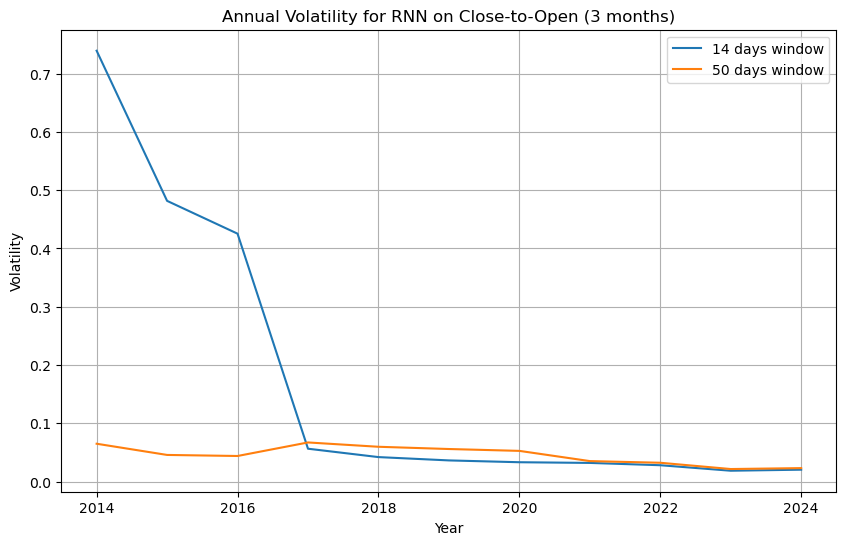

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    332.949646    405.651917    376.177032    0.009209
1   2015    221.764511    466.088013    260.789673    0.007592
2   2016    386.617249    930.909424    589.598022    0.005361
3   2017    829.696716  18408.445312   2550.803711    0.012641
4   2018   3314.065674  16198.490234   6970.221680    0.011990
5   2019   3430.526123  11852.857422   7826.993652    0.009452
6   2020   5299.904297  26097.367188   9587.297852    0.008933
7   2021  26842.632812  64842.632812  47780.929688    0.013434
8   2022  16318.165039  48538.535156  23213.832031    0.010364
9   2023  16605.830078  44085.777344  27782.435547    0.007245
10  2024  40136.015625  71022.562500  62256.101562    0.009784


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    216.975708    290.029510    260.158112    0.016574
1   2015    104.199272    351.582642    144.873093    0.017565
2   2016    270.661407    813.490173    471.742950    0.009601
3   2017    703.545471  18170.255859   2415.381104    0.016243
4   2018   3161.004883  15956.890625   6804.084473    0.016945
5   2019   3289.451416  11675.332031   7684.844727    0.013128
6   2020   5027.679199  25675.847656   9383.601562    0.011644
7   2021  26375.914062  63661.976562  46669.488281    0.016845
8   2022  16000.895508  47892.550781  22791.443359    0.013400
9   2023  16306.184570  43398.117188  27247.843750    0.009526
10  2024  39299.066406  69267.460938  61138.820312    0.011181


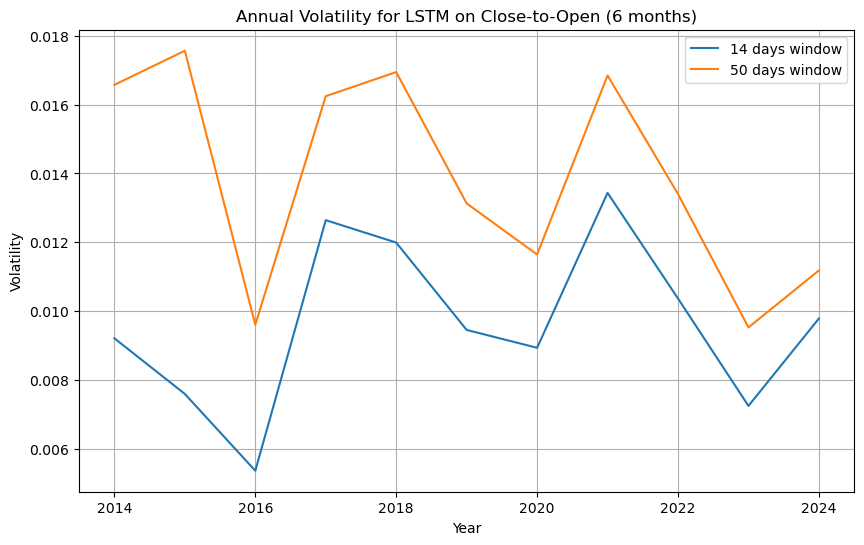

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    292.298889    336.984009    314.675781    0.008579
1   2015    239.033081    373.008667    254.661270    0.005859
2   2016    320.661835    763.520752    455.333130    0.006665
3   2017    673.804382  19493.619141   2636.056885    0.017026
4   2018   3458.866455  17413.898438   7207.504395    0.017554
5   2019   3602.468018  12719.529297   8103.445801    0.013880
6   2020   5224.713867  26575.857422   9904.345703    0.013856
7   2021  27241.941406  65992.070312  48133.214844    0.017256
8   2022  16562.654297  49204.085938  23628.138672    0.014348
9   2023  16898.695312  44374.339844  28012.931641    0.010058
10  2024  39911.296875  71802.234375  63195.796875    0.011999


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    689.819092    730.667725    719.624634    0.003823
1   2015    588.548645    776.424316    611.777893    0.002816
2   2016    739.140137   1255.199829    959.363770    0.003161
3   2017   1271.725586  18755.281250   3004.020752    0.011214
4   2018   3571.331543  17666.451172   7166.203613    0.018841
5   2019   3720.833252  12849.089844   8201.471680    0.014771
6   2020   5640.176270  27208.701172  10107.315430    0.014595
7   2021  27631.671875  67782.265625  49909.796875    0.020745
8   2022  17006.265625  49593.394531  24238.933594    0.016510
9   2023  17110.388672  45426.265625  28744.888672    0.012305
10  2024  41012.710938  73607.109375  64887.113281    0.013355


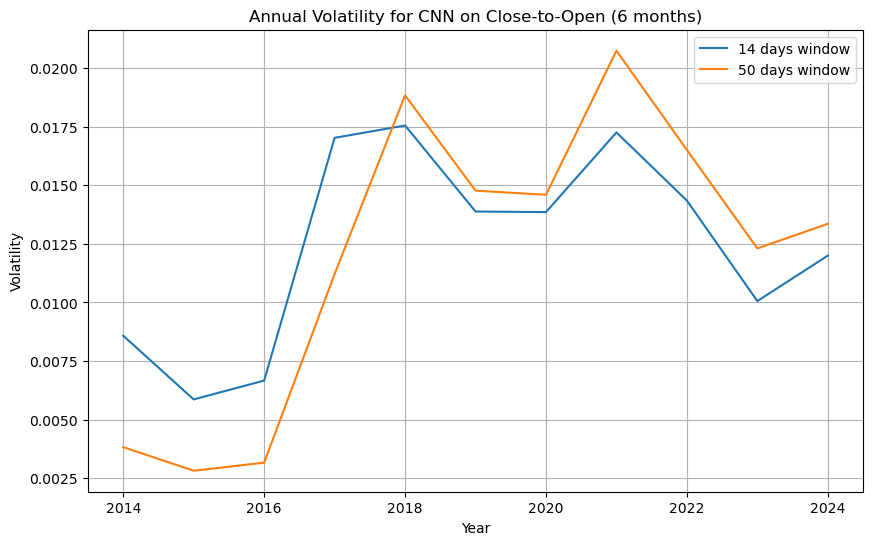

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 6 months, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014     96.150352    221.193207    151.806442    0.065986
1   2015    -46.549896    263.490143     26.762495    9.005822
2   2016    164.396988    836.951111    400.571136    0.031868
3   2017    620.273132  20623.371094   2605.481201    0.044062
4   2018   3307.302490  18754.966797   7209.993652    0.037087
5   2019   3499.484619  13619.566406   8112.343750    0.030923
6   2020   4914.978027  28527.960938  10139.011719    0.029722
7   2021  29710.714844  66661.976562  48693.429688    0.030472
8   2022  16461.794922  48195.261719  24201.031250    0.026789
9   2023  17234.408203  44919.722656  28633.458984    0.017662
10  2024  40477.113281  72279.343750  63648.484375    0.019103


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 6 months, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014   1224.480957   1393.867065   1318.120605    0.025335
1   2015   1039.131226   1536.369019   1172.610107    0.022607
2   2016   1297.113037   2060.294922   1593.568237    0.022295
3   2017   1744.566040  21249.462891   3681.087402    0.047676
4   2018   4121.579590  18378.560547   7916.214844    0.047757
5   2019   4232.253418  14582.055664   8803.927734    0.042250
6   2020   4893.146973  28587.320312  10741.333984    0.040456
7   2021  29740.400391  66982.226562  48862.742188    0.032650
8   2022  16601.125000  48948.441406  24356.064453    0.028978
9   2023  17377.783203  45353.859375  28644.062500    0.018900
10  2024  40493.539062  72819.000000  64069.492188    0.020545


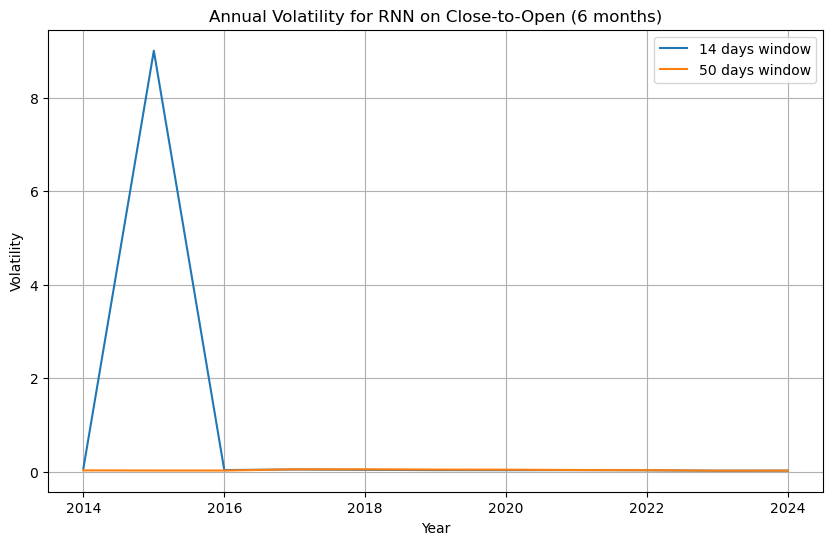

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    317.204559    389.930695    360.097229    0.010270
1   2015    205.826706    452.275848    245.587662    0.008778
2   2016    370.555145    922.128418    574.428345    0.006041
3   2017    810.979919  18437.683594   2536.131836    0.014090
4   2018   3275.117676  16248.491211   6952.125488    0.013263
5   2019   3405.134521  11871.208008   7788.896973    0.010498
6   2020   5163.362793  26223.449219   9544.035156    0.010049
7   2021  27012.314453  64948.593750  47304.039062    0.016142
8   2022  16149.286133  47349.066406  22967.001953    0.012115
9   2023  16460.726562  43762.667969  27470.027344    0.008260
10  2024  39471.640625  71213.007812  62195.523438    0.011921


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step

Annual Statistics for LSTM model on Close-to-Open dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    408.108673    480.805511    451.611267    0.009416
1   2015    294.238129    543.302673    333.894348    0.008077
2   2016    463.390472   1017.690735    670.130310    0.006501
3   2017    912.585022  18818.908203   2673.409668    0.014575
4   2018   3460.949707  16748.587891   7197.330566    0.016341
5   2019   3576.095703  12172.859375   8052.896973    0.012627
6   2020   5473.351074  26751.257812   9858.933594    0.011356
7   2021  27514.089844  66666.078125  48786.910156    0.017873
8   2022  16811.160156  49346.414062  23751.255859    0.013862
9   2023  17033.591797  45170.468750  28350.326172    0.009704
10  2024  40943.261719  72418.695312  63664.414062    0.012311


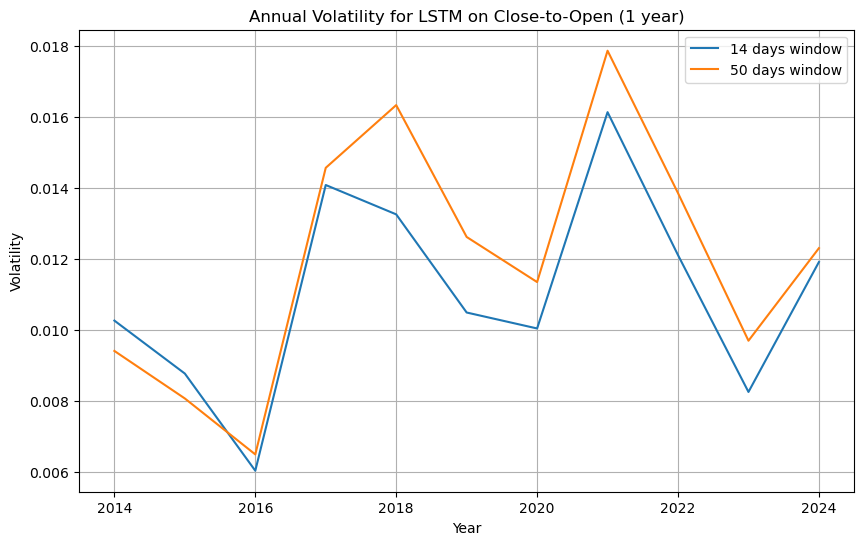

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    571.690735    629.976440    606.486633    0.004042
1   2015    501.379028    668.400879    518.462952    0.003167
2   2016    613.004272   1124.499268    793.207642    0.003561
3   2017   1088.617554  20277.298828   3069.772705    0.014914
4   2018   3967.969238  18239.427734   7708.157715    0.016387
5   2019   4053.962402  13313.468750   8533.974609    0.013632
6   2020   6070.575195  27975.589844  10369.942383    0.013887
7   2021  28730.800781  69164.148438  50464.542969    0.019363
8   2022  17270.519531  50841.964844  24790.304688    0.015321
9   2023  17571.476562  46188.207031  29310.931641    0.010891
10  2024  41781.519531  75244.406250  65941.140625    0.013137


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Annual Statistics for CNN model on Close-to-Open dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    485.081726    503.567200    497.696899    0.003701
1   2015    432.153870    529.433167    441.430359    0.003097
2   2016    516.119446    944.835938    688.973389    0.004952
3   2017    949.789001  18414.761719   3043.496582    0.017273
4   2018   3520.287109  16548.181641   6876.730469    0.023797
5   2019   3628.564453  11886.112305   7651.560059    0.017968
6   2020   5463.971191  26260.000000   9511.335938    0.017147
7   2021  26887.378906  65010.925781  46536.109375    0.023961
8   2022  15772.495117  45743.960938  22943.566406    0.020805
9   2023  16187.852539  43057.886719  27196.806641    0.014099
10  2024  38356.578125  70451.085938  61148.460938    0.015449


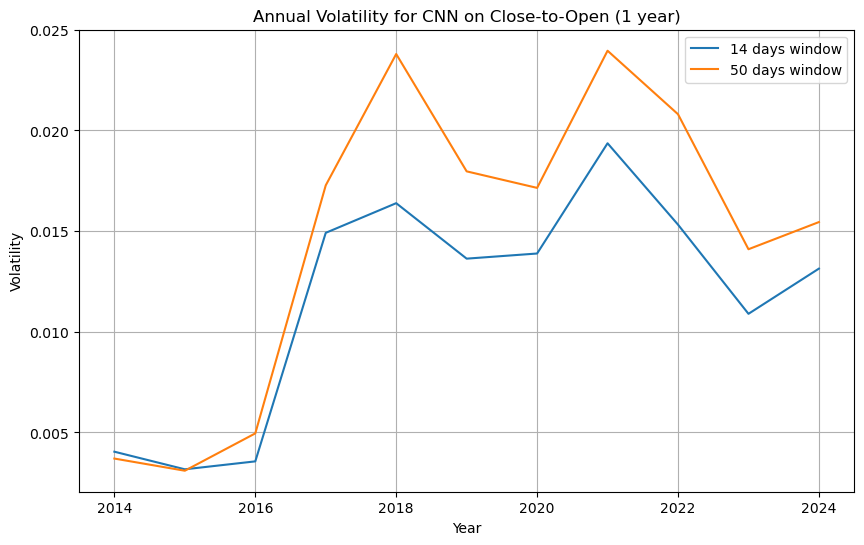

C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 1 year, window adaptation 14 days:
    Year           Min           Max        Median  Volatility
0   2014    -78.066162     54.013962    -23.315847    2.651243
1   2015   -201.424850     86.412376   -139.407776    0.210999
2   2016    -21.011374    628.042053    208.032074    0.430088
3   2017    413.305359  20329.546875   2308.424805    0.052155
4   2018   2858.134033  17865.847656   6851.650391    0.038030
5   2019   3137.314697  13163.436523   7827.571289    0.032224
6   2020   4394.450684  28139.164062   9703.228516    0.031008
7   2021  29456.634766  67730.945312  49146.503906    0.030425
8   2022  15958.446289  48657.105469  23914.798828    0.027990
9   2023  16845.548828  45528.789062  28489.066406    0.018275
10  2024  40860.929688  72484.828125  64448.457031    0.018656


C:\Users\parid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

Annual Statistics for RNN model on Close-to-Open dataset, 1 year, window adaptation 50 days:
    Year           Min           Max        Median  Volatility
0   2014    242.218140    632.382080    431.681152    0.164407
1   2015     37.538788    808.605713    341.296478    0.195152
2   2016    260.990417   1199.572510    637.815186    0.115467
3   2017    328.399719  20791.910156   2644.789551    0.149859
4   2018   2962.723145  18978.361328   7466.344238    0.069457
5   2019   3055.156494  13860.543945   8144.267090    0.070801
6   2020   4152.370117  28238.421875  10193.037109    0.060466
7   2021  28209.927734  67482.710938  48636.097656    0.037081
8   2022  16022.423828  48302.824219  23897.523438    0.034488
9   2023  17055.591797  45013.531250  28256.248047    0.022369
10  2024  39962.335938  72708.640625  63619.746094    0.021581


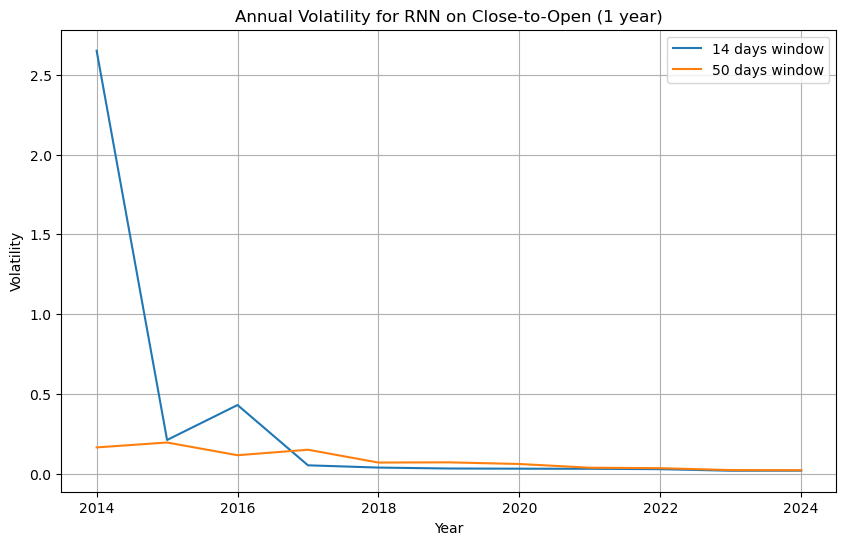

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



for dataset_name, (data, scaler) in datasets.items():
    results[dataset_name] = {}
    for interval_name, time_step in intervals.items():
        results[dataset_name][interval_name] = {}
        X_train, Y_train = create_dataset(data, time_step)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

        for model_name, model_function in models.items():
            results[dataset_name][interval_name][model_name] = {}
            plt.figure(figsize=(10, 6))

            for window_name, window_step in window_adaptations.items():
                X_window_train, Y_window_train = create_dataset(data, window_step)
                X_window_train = X_window_train.reshape(X_window_train.shape[0], X_window_train.shape[1], 1)

                model = model_function((X_window_train.shape[1], 1))
                model.fit(X_window_train, Y_window_train, epochs=10, batch_size=32, verbose=0)

                predictions = model.predict(X_window_train)

                if dataset_name == 'Day' or dataset_name == 'Close-to-Open':
                    predictions = np.concatenate([predictions, predictions], axis=1)

                predicted_price = scaler.inverse_transform(predictions)[:, 0]  # Take only the first column after inverse transform
                investment_result = (predicted_price[-1] / predicted_price[0]) * initial_investment
                results[dataset_name][interval_name][model_name][window_name] = investment_result

                if len(df['Date'][window_step + 1:]) != len(predicted_price):
                    min_length = min(len(df['Date'][window_step + 1:]), len(predicted_price))
                    dates = df['Date'][window_step + 1:][:min_length]
                    prices = predicted_price[:min_length]
                else:
                    dates = df['Date'][window_step + 1:]
                    prices = predicted_price

                volatility_df = pd.DataFrame({'Date': dates, 'Predicted': prices})
                volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])
                volatility_df['Year'] = volatility_df['Date'].dt.year
                volatility_df['Volatility'] = volatility_df['Predicted'].pct_change().rolling(window=window_step).std()

                # Calculate statistics for each year
                annual_stats = volatility_df.groupby('Year').agg(
                    Min=('Predicted', 'min'),
                    Max=('Predicted', 'max'),
                    Median=('Predicted', 'median'),
                    Volatility=('Volatility', 'mean')
                ).reset_index()

                # Print the results
                print(f"\nAnnual Statistics for {model_name} model on {dataset_name} dataset, {interval_name}, window adaptation {window_name}:")
                print(annual_stats)

                # Plotting the annual volatility
                plt.plot(annual_stats['Year'], annual_stats['Volatility'], label=f'{window_name} window')

            plt.xlabel('Year')
            plt.ylabel('Volatility')
            plt.title(f'Annual Volatility for {model_name} on {dataset_name} ({interval_name})')
            plt.legend()
            plt.grid(True)
            plt.show()


In [31]:
for dataset_name, interval_results in results.items():
    for interval_name, window_results in interval_results.items():
        print(f"\n{dataset_name} - {interval_name}")
        for window_name, model_results in window_results.items():
            print(f"  Adaptation with {window_name}:")
            for model_name, result in model_results.items():
                if 'Volatility' not in model_name:
                    print(f"    {model_name} model: ${result:.2f}")
                else:
                    print(f"    {model_name}:")
                    print(result)


Overnight - 3 months
  Adaptation with 14 days:
    LSTM model: $7732.24
    CNN model: $15856.06
    RNN model: $15849.53
  Adaptation with 50 days:
    LSTM model: $21658.72
    CNN model: $8598.98
    RNN model: $3849.67

Overnight - 6 months
  Adaptation with 14 days:
    LSTM model: $-192067.81
    CNN model: $32214.67
    RNN model: $-33188.56
  Adaptation with 50 days:
    LSTM model: $8147.98
    CNN model: $8021.87
    RNN model: $10723.73

Overnight - 1 year
  Adaptation with 14 days:
    LSTM model: $11745.79
    CNN model: $10862.71
    RNN model: $9021.56
  Adaptation with 50 days:
    LSTM model: $-115433.30
    CNN model: $13327.17
    RNN model: $13007.55

Day - 3 months
  Adaptation with 14 days:
    LSTM model: $8359.33
    CNN model: $22143.69
    RNN model: $25150.14
  Adaptation with 50 days:
    LSTM model: $20147.21
    CNN model: $12658.90
    RNN model: $9589.68

Day - 6 months
  Adaptation with 14 days:
    LSTM model: $13329.88
    CNN model: $37827.64
    R

In [ ]:
# # df['Week'] = df['Date'].dt.isocalendar().week
# # df['Month'] = df['Date'].dt.month
# df['Year'] = df['Date'].dt.year

# # weekly_labels = df.groupby(['Year', 'Week'])['Label'].value_counts(normalize=True).unstack().fillna(0)
# # monthly_labels = df.groupby(['Year', 'Month'])['Label'].value_counts(normalize=True).unstack().fillna(0)
# annual_labels = df.groupby(['Year'])['Label'].value_counts(normalize=True).unstack().fillna(0)

# # print("\nWeekly Label Distribution:")
# # print(weekly_labels)

# # print("\nMonthly Label Distribution:")
# # print(monthly_labels)

# print("\nAnnual Label Distribution:")
# print(annual_labels)